# DS-6014 Bayesian Machine Learning Final Project
#### Haizhu Hong, Yiran Zheng

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.corpus import stopwords
import json 
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import theano
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(2018)
from sklearn.model_selection import train_test_split
import re
import arviz as az
from sklearn.metrics import classification_report

### load the data

In [2]:
#Dow Jones Industrial Average (DJIA) is used to "prove the concept".
stock=pd.read_csv("../data/upload_DJIA_table.csv")
stock.head()

Date          Open          High           Low         Close  \
0  2016-07-01  17924.240234  18002.380859  17916.910156  17949.369141   
1  2016-06-30  17712.759766  17930.609375  17711.800781  17929.990234   
2  2016-06-29  17456.019531  17704.509766  17456.019531  17694.679688   
3  2016-06-28  17190.509766  17409.720703  17190.509766  17409.720703   
4  2016-06-27  17355.210938  17355.210938  17063.080078  17140.240234   

      Volume     Adj Close  
0   82160000  17949.369141  
1  133030000  17929.990234  
2  106380000  17694.679688  
3  112190000  17409.720703  
4  138740000  17140.240234

In [3]:
#date is the date and followed by top25 topics in redditnews,
#label is binary classification:
#"1" when DJIA Adj Close value rose or stayed as the same;
#"0" when DJIA Adj Close value decreased.

combined=pd.read_csv("../data/Combined_News_DJIA.csv")
combined.head()

Date  Label                                               Top1  \
0  2008-08-08      0  b"Georgia 'downs two Russian warplanes' as cou...   
1  2008-08-11      1  b'Why wont America and Nato help us? If they w...   
2  2008-08-12      0  b'Remember that adorable 9-year-old who sang a...   
3  2008-08-13      0  b' U.S. refuses Israel weapons to attack Iran:...   
4  2008-08-14      1  b'All the experts admit that we should legalis...   

                                                Top2  \
0            b'BREAKING: Musharraf to be impeached.'   
1        b'Bush puts foot down on Georgian conflict'   
2                 b"Russia 'ends Georgia operation'"   
3  b"When the president ordered to attack Tskhinv...   
4  b'War in South Osetia - 89 pictures made by a ...   

                                                Top3  \
0  b'Russia Today: Columns of troops roll into So...   
1  b"Jewish Georgian minister: Thanks to Israeli ...   
2  b'"If we had no sexual harassment we would hav...   
3  b' Israel clears troops who killed Reuters cam...   
4  b'Swedish wrestler Ara Abrahamian throws away ...   

                                                Top4  \
0  b'Russian tanks are moving towards the capital...   
1  b'Georgian army flees in disarray as Russians ...   
2  b"Al-Qa'eda is losing support in Iraq because ...   
3  b'Britain\'s policy of being tough on drugs is...   
4  b'Russia exaggerated the death toll in South O...   

                                                Top5  \
0  b"Afghan children raped with 'impunity,' U.N. ...   
1      b"Olympic opening ceremony fireworks 'faked'"   
2  b'Ceasefire in Georgia: Putin Outmaneuvers the...   
3  b'Body of 14 year old found in trunk; Latest (...   
4  b'Missile That Killed 9 Inside Pakistan May Ha...   

                                                Top6  \
0  b'150 Russian tanks have entered South Ossetia...   
1  b'What were the Mossad with fraudulent New Zea...   
2  b'Why Microsoft and Intel tried to kill the XO...   
3  b'China has moved 10 *million* quake survivors...   
4  b"Rushdie Condemns Random House's Refusal to P...   

                                                Top7  \
0  b"Breaking: Georgia invades South Ossetia, Rus...   
1  b'Russia angered by Israeli military sale to G...   
2  b'Stratfor: The Russo-Georgian War and the Bal...   
3  b"Bush announces Operation Get All Up In Russi...   
4  b'Poland and US agree to missle defense deal. ...   

                                                Top8  ...  \
0  b"The 'enemy combatent' trials are nothing but...  ...   
1  b'An American citizen living in S.Ossetia blam...  ...   
2  b"I'm Trying to Get a Sense of This Whole Geor...  ...   
3             b'Russian forces sink Georgian ships '  ...   
4  b'Will the Russians conquer Tblisi? Bet on it,...  ...   

                                               Top16  \
0  b'Georgia Invades South Ossetia - if Russia ge...   
1  b'Israel and the US behind the Georgian aggres...   
2  b'U.S. troops still in Georgia (did you know t...   
3                      b'Elephants extinct by 2020?'   
4  b'Bank analyst forecast Georgian crisis 2 days...   

                                               Top17  \
0                b'Al-Qaeda Faces Islamist Backlash'   
1  b'"Do not believe TV, neither Russian nor Geor...   
2       b'Why Russias response to Georgia was right'   
3  b'US humanitarian missions soon in Georgia - i...   
4  b"Georgia confict could set back Russia's US r...   

                                               Top18  \
0  b'Condoleezza Rice: "The US would not act to p...   
1  b'Riots are still going on in Montreal (Canada...   
2  b'Gorbachev accuses U.S. of making a "serious ...   
3             b"Georgia's DDOS came from US sources"   
4  b'War in the Caucasus is as much the product o...   

                                               Top19  \
0  b'This is a busy day:  The European Union has ...   
1    b'China to overtake US as largest manufac

### data cleaning and preprocessing

### First check if there is any Null value in the data

In [4]:
stock.isnull().values.any()

False

In [5]:
combined.isnull().values.any()

True

In [6]:
#try to locate the null value in the combined data
combined.isnull().sum()

Date     0
Label    0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    1
Top24    3
Top25    3
dtype: int64

In [7]:
# filling the null values with " "
combined['Top23'].fillna(" ",inplace=True)
combined['Top24'].fillna(" ",inplace=True)
combined['Top25'].fillna(" ",inplace=True)

In [8]:
stemmer = PorterStemmer()

In [9]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [10]:
# Set stop words
stopWords = set(stopwords.words('english'))
# Remove stop words and Tokenization
def preprocessor(text): 
    result=""
    tokens = nltk.word_tokenize(text)
    for word in tokens:
        if word not in stopWords:
            result=result+lemmatize_stemming(word)
            result=result+" "
    return result

In [11]:
#remove b' and convert to lower case for all the news headlines
Tops=[x for x in combined.columns if x.startswith("Top")]
for Top in Tops:
    combined[Top] = combined[Top].str[2:]
    combined[Top] = combined[Top].str.lower()
combined['headlines'] = combined[Tops].apply(lambda x: " ".join(x.astype(str)), axis=1)

combined['headlines'] = combined['headlines'].replace("[^a-zA-Z]"," ",regex=True)
combined['headlines'] = combined['headlines'].apply(preprocessor)
combined.at[0,'headlines']

'georgia down two russian warplan countri move brink war break musharraf impeach russia today column troop roll south ossetia footag fight youtub russian tank move toward capit south ossetia reportedli complet destroy georgian artilleri fire afghan children rap impun u n offici say sick three year old rap noth russian tank enter south ossetia whilst georgia shoot two russian jet break georgia invad south ossetia russia warn would interven side enemi combat trial noth sham salim haman sentenc year keep longer anyway feel like georgian troop retreat osettain capit presum leav sever hundr peopl kill video u prep georgia war russia rice give green light israel attack iran say u veto isra militari op announc class action lawsuit behalf american public fbi russia georgia war nyt top stori open ceremoni olymp fuck disgrac yet proof declin journal china tell bush stay countri affair world war iii start today georgia invad south ossetia russia get involv nato absorb georgia unleash full scale w

In [12]:
from collections import Counter
Counter(" ".join(combined['headlines']).split()).most_common(100)

[('say', 4846),
 ('year', 3148),
 ('kill', 2668),
 ('us', 2624),
 ('world', 2298),
 ('govern', 2257),
 ('new', 2131),
 ('peopl', 1901),
 ('countri', 1859),
 ('polic', 1838),
 ('israel', 1814),
 ('protest', 1774),
 ('state', 1759),
 ('attack', 1747),
 ('e', 1688),
 ('war', 1636),
 ('u', 1625),
 ('find', 1596),
 ('report', 1524),
 ('china', 1482),
 ('use', 1458),
 ('one', 1429),
 ('presid', 1416),
 ('call', 1413),
 ('right', 1406),
 ('forc', 1393),
 ('ban', 1292),
 ('make', 1270),
 ('first', 1265),
 ('isra', 1250),
 ('take', 1234),
 ('korea', 1227),
 ('russia', 1205),
 ('law', 1191),
 ('time', 1160),
 ('offici', 1156),
 ('death', 1155),
 ('million', 1145),
 ('minist', 1132),
 ('militari', 1122),
 ('uk', 1113),
 ('bank', 1084),
 ('plan', 1078),
 ('court', 1077),
 ('nation', 1061),
 ('iran', 1038),
 ('two', 1035),
 ('get', 1027),
 ('man', 1021),
 ('go', 1016),
 ('arrest', 1005),
 ('russian', 1000),
 ('amp', 991),
 ('nuclear', 982),
 ('news', 978),
 ('human', 961),
 ('day', 958),
 ('drug', 

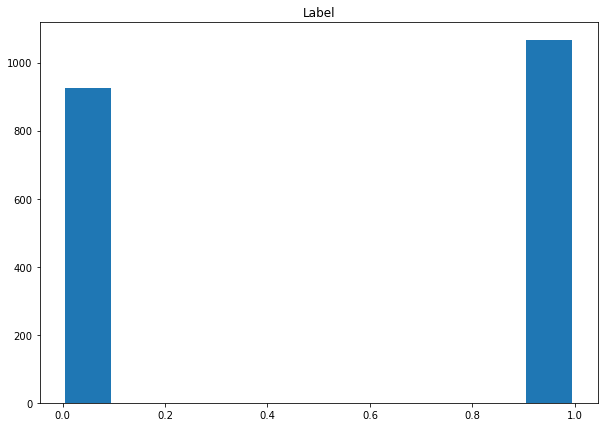

In [13]:
combined.hist(column='Label', grid=False, figsize=(10,7), rwidth=0.9);

### split the data into training and testing dataset

### Build LDA model to predict topics and word 

In [14]:
class LDA_trains:
    """Creates a class for Latent Dirichlet Allocation using headlines in redditnews
    Input:
        reports = list of headlines
        N_topics = number of topics for LDA to produce
        N_words = the number of words to show in a topic
        new_report = narrative for a new accident report not in the training set
    Methods:
        Topics = Print the list of topics in the selected headlines
        Predict_Topics = Show the predicted probabilities for topics for a new headlines"""
    
    def __init__(self, headlines, N_topics=3, N_words = 10):
        # the news headlines
        self.headlines = headlines
        # initialize variables
        self.N_topics = N_topics
        self.N_words = N_words
        
        # Get the word counts in the headlines
        self.countVectorizer = CountVectorizer(stop_words='english')
        self.termFrequency = self.countVectorizer.fit_transform(self.headlines)
        self.Words = self.countVectorizer.get_feature_names()
        
    def Topics(self):
        
        # Obtain the estimates for the LDA model 
        self.lda = LatentDirichletAllocation(n_components=self.N_topics)
        self.lda.fit(self.termFrequency)
        
        # For each of the topics in the model add the top N_words the list of topics
        topics = list()
        for topic in self.lda.components_:
            topics.append([self.Words[i] for i in topic.argsort()[:-self.N_words - 1:-1]])
        # Create column names for the output matrix
        cols = list()
        for i in range(self.N_words):
            cols.append("Word "+(str(i)))
            
        # Create a dataframe with the topic no. and the words in each topic 
        # output this dataframe 
        Topics_df =pd.DataFrame(topics, columns = cols)
        Topics_df.index.name = "Topics"        
        return Topics_df
    
    def Predict_Topics(self, new_headlines):
        self.new_headlines = new_headlines
        
        # Get the list of new headlines
        # and the number of new narratives
        N_new_headlines = len(self.new_headlines)
        
        
        # For each of the new headlines 
        # obtain the estimated probabilities for each of the topics
        # in each of the new narratives as estimated by the LDA results
        # on the training set 
        new_headlines_topics = list()
        for title in self.new_headlines:
            new_headlines = preprocessor(title)
            new_headlines_topics.append(self.lda.transform(self.countVectorizer.transform([new_headlines])))       
        
        # Recast the list of probabilities for topics as an array 
        # of size no. of new headlines X no. of topics
        new_headlines_topics = np.array(new_headlines_topics).reshape(N_new_headlines, self.N_topics)
        
        # Create column names for the output dataframe
        cols = list()
        for i in range(self.N_topics):
            cols.append("Topic "+(str(i)))        
        
        # Create the dataframe whose rows contain topic probabilities for 
        # specificed narratives/headlines
        New_Headlines_df = pd.DataFrame(new_headlines_topics, columns = cols )
        New_Headlines_df.insert(0, 'headlines', self.new_headlines)       
        
        return New_Headlines_df
                

### Number of Topics = 2

In [15]:
lda_model = LDA_trains(headlines = combined['headlines'], N_topics = 2, N_words = 10)

In [16]:
topics= lda_model.Topics()

In [17]:
topics_dist = lda_model.Predict_Topics(combined['headlines'])

In [18]:
topics

Word 0    Word 1 Word 2  Word 3  Word 4  Word 5    Word 6   Word 7  \
Topics                                                                        
0           say      year   kill   world  govern     new   countri    peopl   
1       protest  wikileak  egypt  assang   libya  kileak  egyptian  mubarak   

         Word 8  Word 9  
Topics                   
0        israel   polic  
1       nuclear  govern

In [19]:
topics_dist

headlines   Topic 0   Topic 1
0     georgia down two russian warplan countri move ...  0.997124  0.002876
1     wont america nato help us wont help us help ir...  0.995964  0.004036
2     rememb ador year old sing open ceremoni fake r...  0.996625  0.003375
3     u refus israel weapon attack iran report presi...  0.996747  0.003253
4     expert admit legalis drug war south osetia pic...  0.996250  0.003750
...                                                 ...       ...       ...
1984  rclay rb share suspend trade tank pe say churc...  0.981607  0.018393
1985  scientist australia want save great barrier re...  0.997801  0.002199
1986  plosion airport istanbul meni former presid te...  0.972743  0.027257
1987  maica propos marijuana dispens tourist airport...  0.997658  0.002342
1988  year old woman mexico citi final receiv birth ...  0.998048  0.001952

[1989 rows x 3 columns]

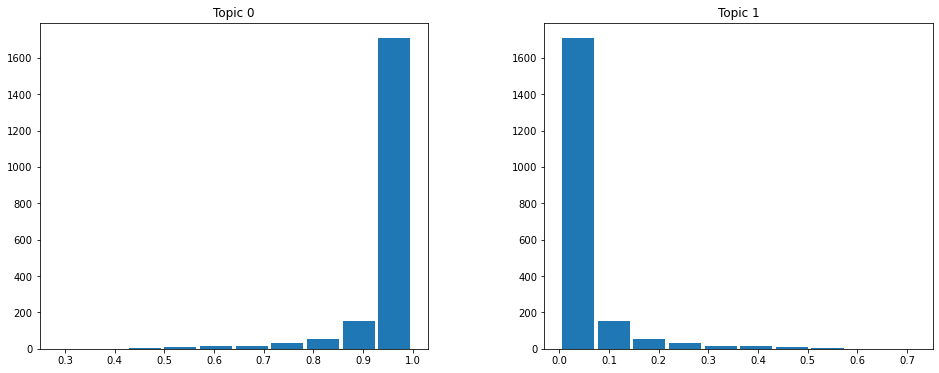

In [20]:
topics_dist.hist(grid=False, figsize=(16,6), layout=(1,2), rwidth=0.9);

In [21]:
predictor = list(topics_dist.columns[1:])
X = topics_dist.iloc[:,1:]
k = len(predictor)
y = combined.Label.astype(float)

### split the data into training and testing dataset

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

In [23]:
inn = theano.shared(X_train.values)
out = theano.shared(y_train.values)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, β0]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 457 seconds.
The acceptance probability does not match the target. It is 0.9085550282917031, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


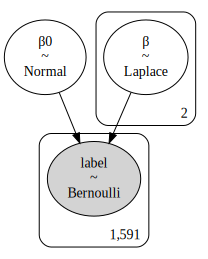

In [24]:
# Get the sampling results for comparison

with pm.Model() as sampling_model: 
    
    # Intercept term
    β0 = pm.Normal('β0', mu=0, sd=1)
    
    # Beta coefficients for predictor variables
    β = pm.Laplace('β', mu = 0.0, b = 5.0, shape=k)
    
    # Calculate logit from the normal variables, and add intercept
    logit = pm.math.dot(inn,β) + β0
    logistic = pm.math.sigmoid(logit)

    # Pass the logits to a Bernoulli outcome, with the observed data
    y_pred = pm.Bernoulli('label', p=logistic, observed=out)

    # Sample
    trace_main = pm.sample(10000, cores=4, random_seed=666)
    
# Graph the logistic model
pm.model_to_graphviz(sampling_model)

In [25]:
inn.set_value(X_test.values)
out.set_value(y_test.values)

with sampling_model:
    ppc = pm.sample_posterior_predictive(trace_main, samples=500, progressbar=False, random_seed=666)

C:\Users\15182\anaconda3\lib\site-packages\pymc3\sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [26]:
pred = ppc['label'].mean(axis=0) > 0.5
pred = pred.astype(int)

In [27]:
confusion_matrix(y_test, pred)

array([[ 15, 170],
       [ 27, 186]], dtype=int64)

In [28]:
accuracy_score(y_test, pred)*100

50.502512562814076

In [29]:
print(classification_report(y_test, pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.36      0.08      0.13       185
           1       0.52      0.87      0.65       213

    accuracy                           0.51       398
   macro avg       0.44      0.48      0.39       398
weighted avg       0.45      0.51      0.41       398



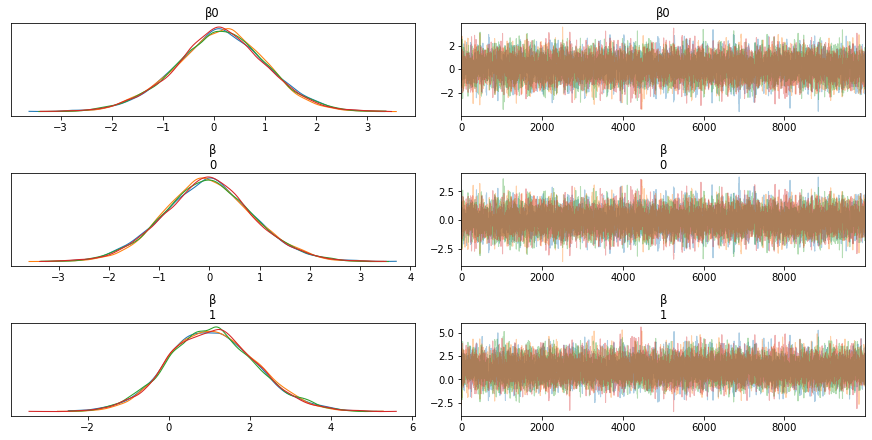

In [30]:
with sampling_model:
    az.plot_trace(trace_main)

### Number of Topics = 5

In [31]:
lda_model = LDA_trains(headlines = combined['headlines'], N_topics = 5, N_words = 10)

In [32]:
topics= lda_model.Topics()

In [33]:
topics_dist = lda_model.Predict_Topics(combined['headlines'])

In [34]:
topics

Word 0    Word 1   Word 2  Word 3  Word 4   Word 5     Word 6  \
Topics                                                                   
0           say     korea     year  govern     new    world        ban   
1           say   protest   govern    year    kill    peopl     israel   
2           say      year     kill  attack     new  countri      state   
3           say      year     kill   world  israel      new      state   
4       georgia  georgian  ossetia    lula   rasia     faso  uncontrol   

            Word 7   Word 8   Word 9  
Topics                                
0             kill    china      law  
1            polic      war    world  
2           govern    peopl    polic  
3           govern   russia   attack  
4       tskhinvali  glasgow  caucasu

In [35]:
topics_dist

headlines   Topic 0   Topic 1  \
0     georgia down two russian warplan countri move ...  0.000929  0.132830   
1     wont america nato help us wont help us help ir...  0.001342  0.001348   
2     rememb ador year old sing open ceremoni fake r...  0.001068  0.014427   
3     u refus israel weapon attack iran report presi...  0.001067  0.142096   
4     expert admit legalis drug war south osetia pic...  0.001164  0.001171   
...                                                 ...       ...       ...   
1984  rclay rb share suspend trade tank pe say churc...  0.000834  0.000835   
1985  scientist australia want save great barrier re...  0.210169  0.000722   
1986  plosion airport istanbul meni former presid te...  0.000807  0.000811   
1987  maica propos marijuana dispens tourist airport...  0.000741  0.000744   
1988  year old woman mexico citi final receiv birth ...  0.000674  0.141627   

       Topic 2   Topic 3   Topic 4  
0     0.000928  0.782190  0.083122  
1     0.001334  0.934648  0.061328  
2     0.001063  0.780245  0.203198  
3     0.001062  0.730628  0.125146  
4     0.001163  0.847064  0.149438  
...        ...       ...       ...  
1984  0.996681  0.000837  0.000813  
1985  0.145939  0.642465  0.000705  
1986  0.996785  0.000809  0.000788  
1987  0.997040  0.000745  0.000730  
1988  0.832271  0.024769  0.000659  

[1989 rows x 6 columns]

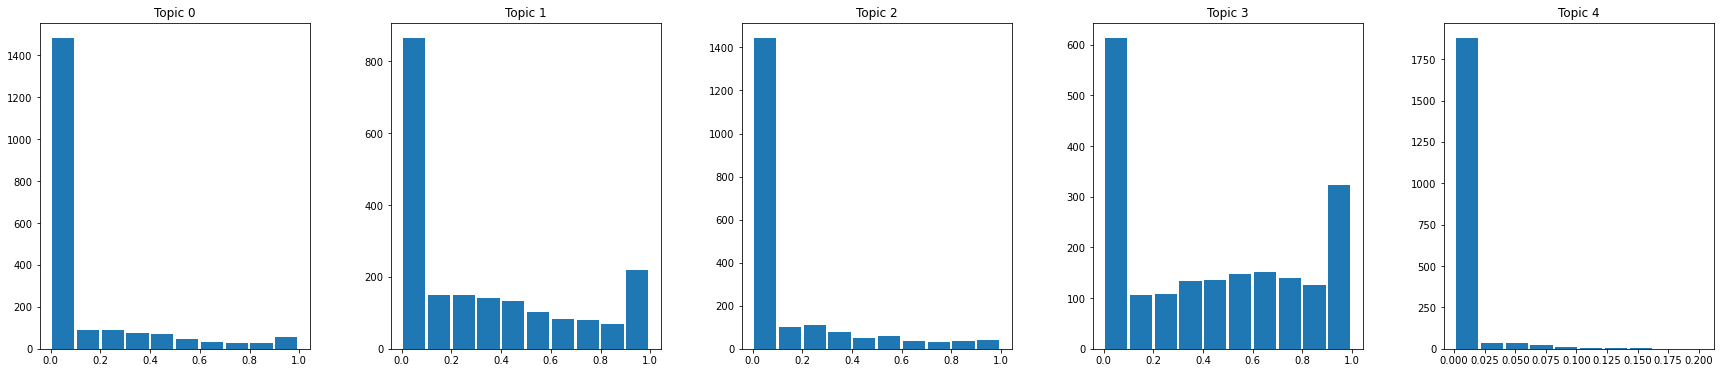

In [36]:
topics_dist.hist(grid=False, figsize=(30,6), layout=(1,5), rwidth=0.9);

In [37]:
predictor = list(topics_dist.columns[1:])
X = topics_dist.iloc[:,1:]
k = len(predictor)
y = combined.Label.astype(float)

### split the data into training and testing dataset

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

In [39]:
inn = theano.shared(X_train.values)
out = theano.shared(y_train.values)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, β0]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 377 seconds.
The acceptance probability does not match the target. It is 0.8844406337243361, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


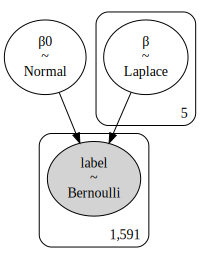

In [40]:
# Get the sampling results for comparison

with pm.Model() as sampling_model: 
    
    # Intercept term
    β0 = pm.Normal('β0', mu=0, sd=1)
    
    # Beta coefficients for predictor variables
    β = pm.Laplace('β', mu = 0.0, b = 5.0, shape=k)
    
    # Calculate logit from the normal variables, and add intercept
    logit = pm.math.dot(inn,β) + β0
    logistic = pm.math.sigmoid(logit)

    # Pass the logits to a Bernoulli outcome, with the observed data
    y_pred = pm.Bernoulli('label', p=logistic, observed=out)

    # Sample
    trace_main = pm.sample(10000, cores=4, random_seed=666)
    
# Graph the logistic model
pm.model_to_graphviz(sampling_model)

In [41]:
inn.set_value(X_test.values)
out.set_value(y_test.values)

with sampling_model:
    ppc = pm.sample_posterior_predictive(trace_main, samples=500, progressbar=False, random_seed=666)

C:\Users\15182\anaconda3\lib\site-packages\pymc3\sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [42]:
pred = ppc['label'].mean(axis=0) > 0.5
pred = pred.astype(int)

In [43]:
confusion_matrix(y_test, pred)

array([[ 18, 167],
       [ 35, 178]], dtype=int64)

In [44]:
accuracy_score(y_test, pred)*100

49.246231155778894

In [45]:
print(classification_report(y_test, pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.34      0.10      0.15       185
           1       0.52      0.84      0.64       213

    accuracy                           0.49       398
   macro avg       0.43      0.47      0.39       398
weighted avg       0.43      0.49      0.41       398



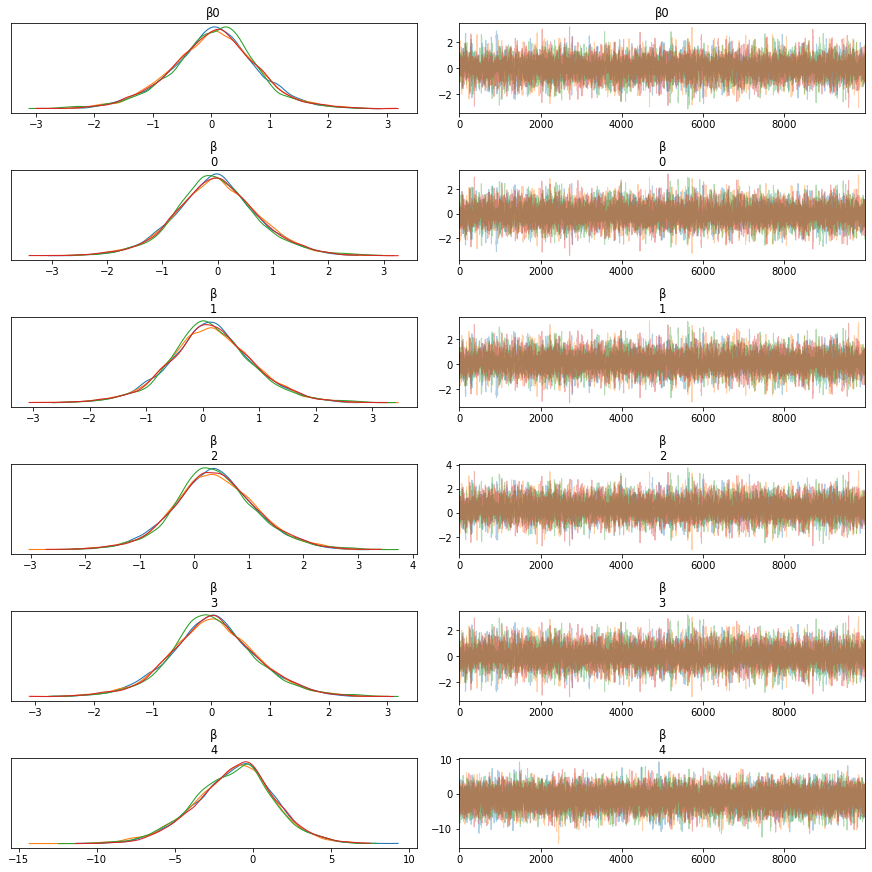

In [46]:
with sampling_model:
    az.plot_trace(trace_main)

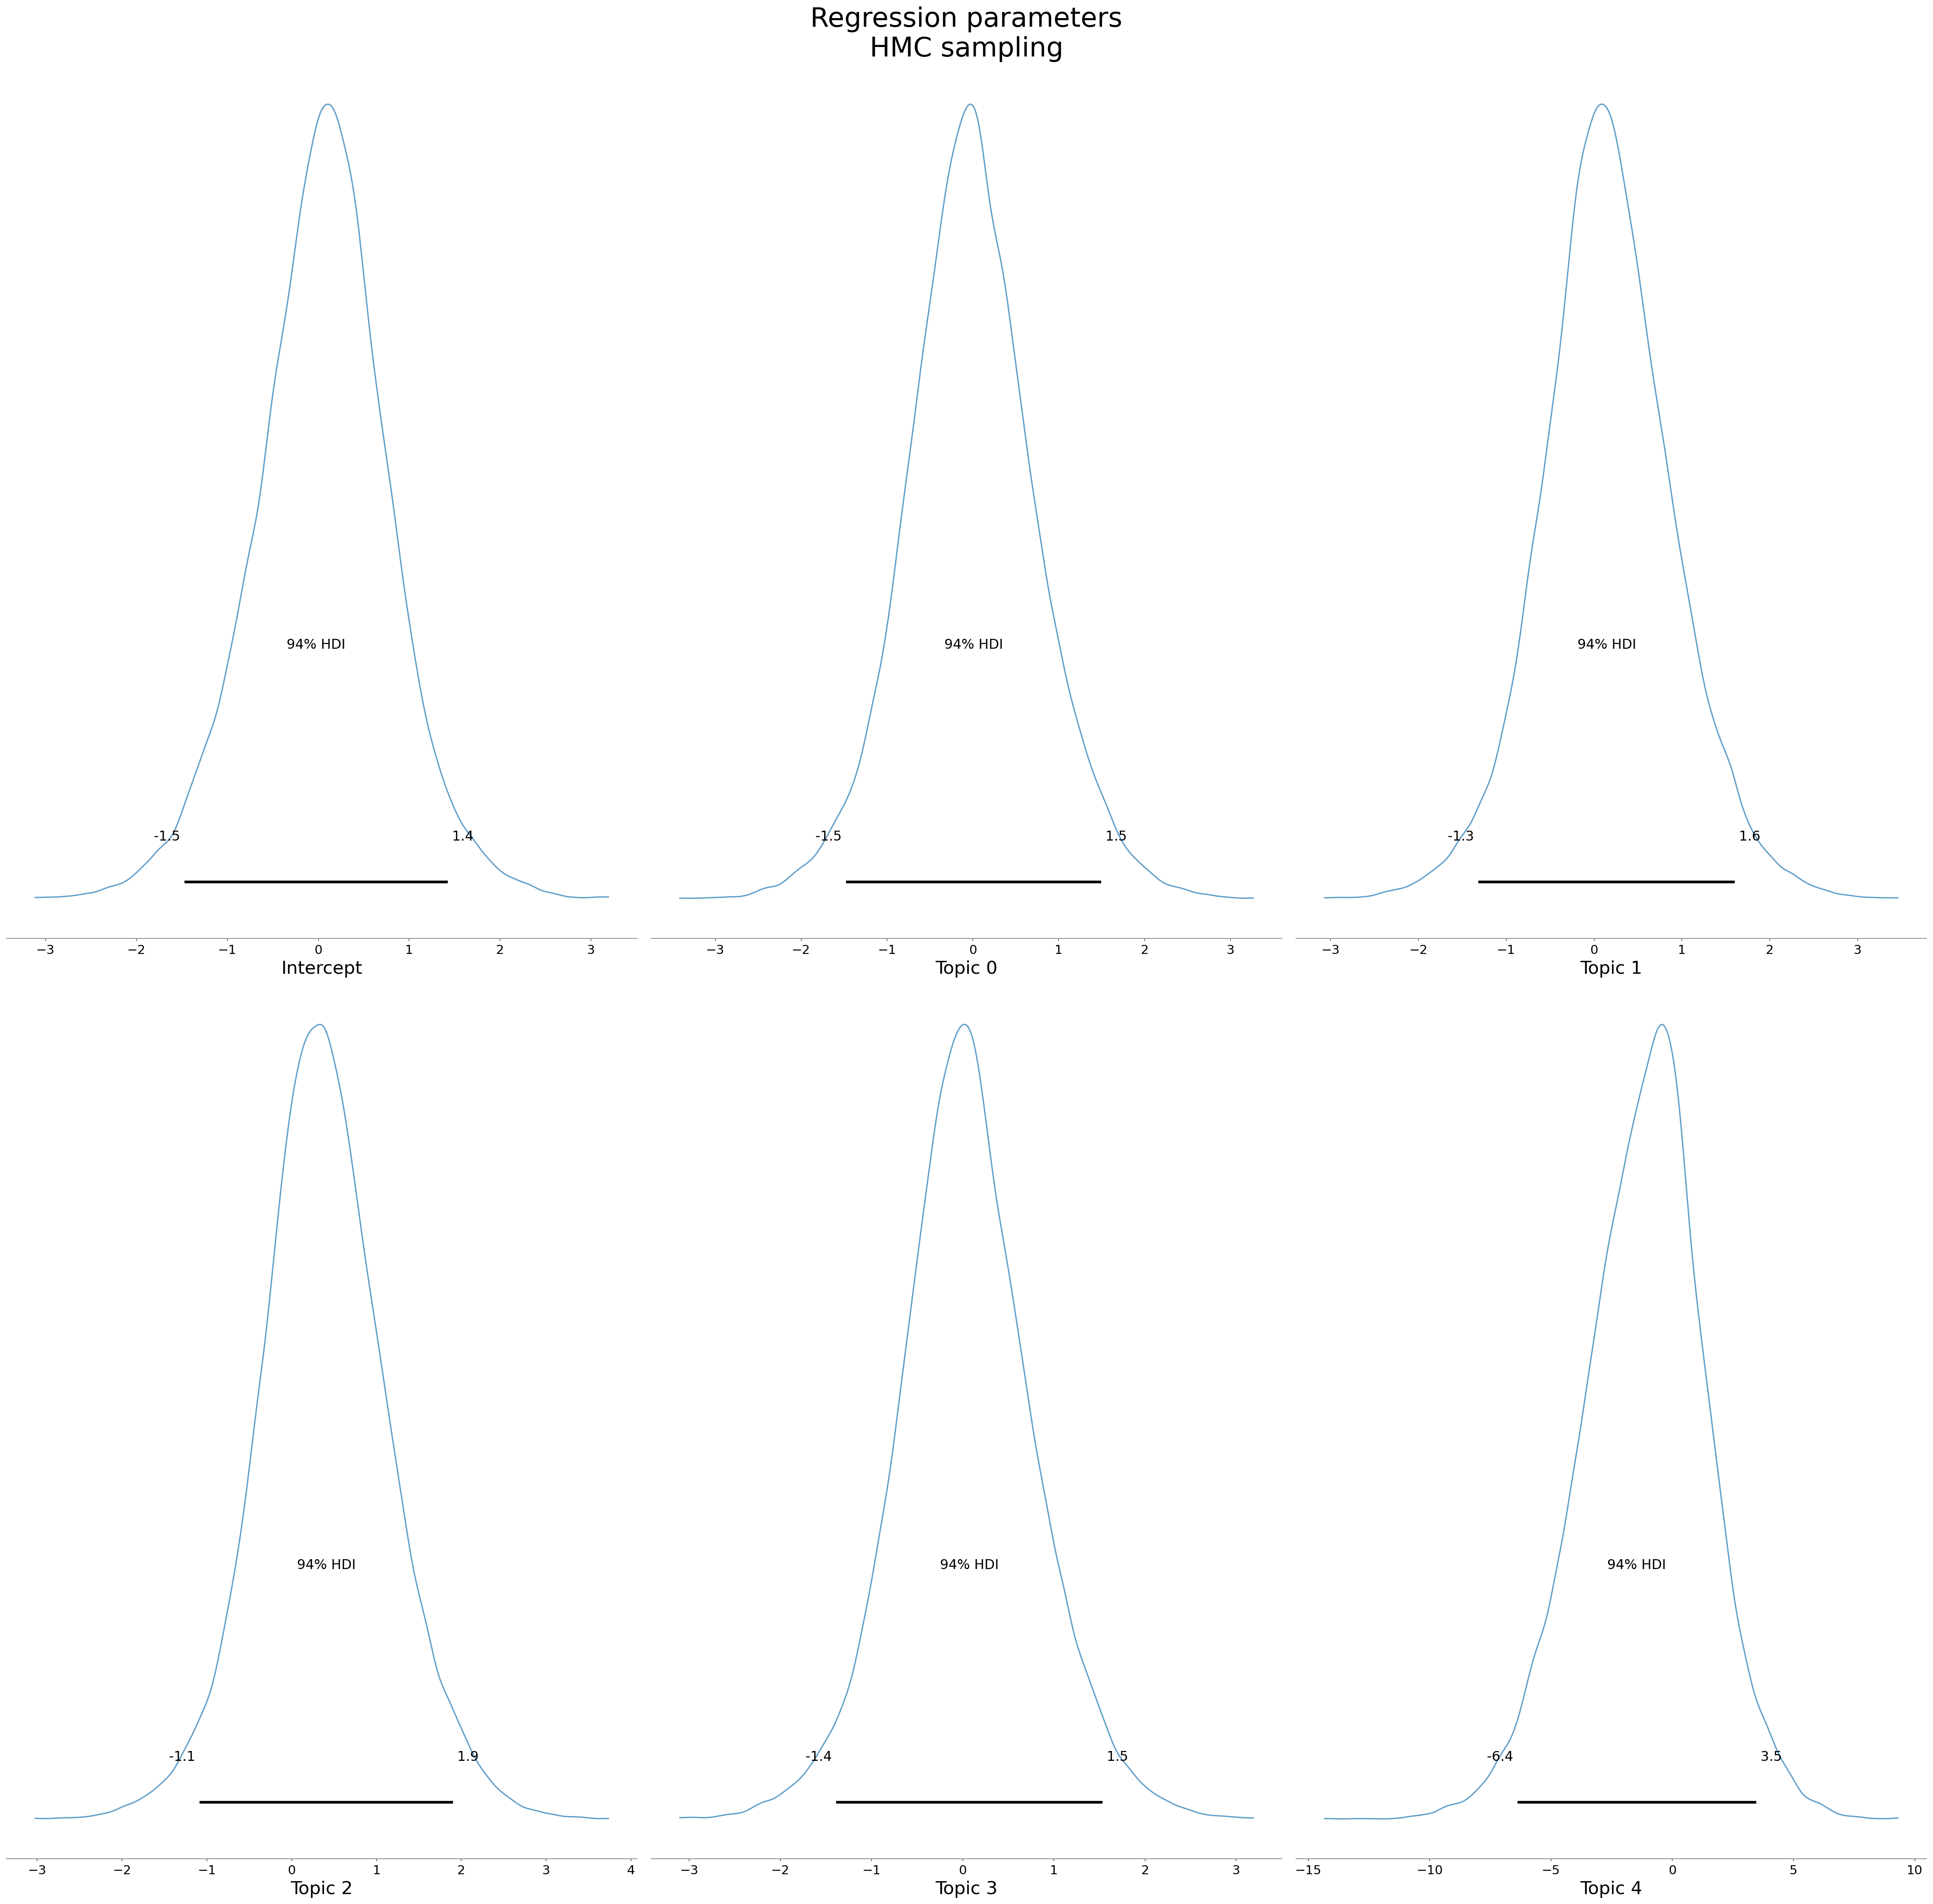

In [47]:
burnin = 100
sample_intercept = trace_main['β0'][burnin:]
sample_betas = trace_main['β'][burnin:]

# Plot posteriors

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 30), dpi=150, constrained_layout=False)

for ax, estimate_sampling, xlabel in zip(axes.ravel(),
                               [sample_intercept] + [sample_betas[:,i] for i in range(k)],
                               ['Intercept'] + predictor):
    
    pm.plot_posterior(estimate_sampling, ax=ax,point_estimate=None,  alpha=0.7)
    
    ax.set_title("")

    ax.set_xlabel(xlabel, fontsize=20)

plt.suptitle("Regression parameters\nHMC sampling", fontsize=30)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

### Number of Topics = 10

In [48]:
lda_model = LDA_trains(headlines = combined['headlines'], N_topics = 10, N_words = 10)

In [49]:
topics= lda_model.Topics()

In [50]:
topics_dist = lda_model.Predict_Topics(combined['headlines'])

In [51]:
topics

Word 0   Word 1  Word 2 Word 3   Word 4     Word 5   Word 6  \
Topics                                                                    
0              say     year  govern   kill    china      polic      ban   
1          protest      say  govern   year    peopl       kill    polic   
2              say     year    kill    new  countri        ban    polic   
3           israel     isra     say   kill     year       gaza    world   
4       bilderberg    edwin   cesar   lula   condol    janeiro     noth   
5              say     year   world   kill   govern        new  countri   
6              say     year     new  world    state       kill   govern   
7          snowden  countri     say    amp      new      world   govern   
8             year      say    news   kill    korea      peopl     drug   
9              say    japan  minist   kill     year  earthquak   govern   

         Word 7    Word 8   Word 9  
Topics                              
0           new     world    korea  
1         world      iran     forc  
2        presid     state   govern  
3           war     polic    peopl  
4         spree  lobbyist  roughli  
5         china    minist      use  
6        attack     korea  countri  
7       million   protest     kill  
8        govern        al    north  
9           pan   tsunami      new

In [52]:
topics_dist

headlines   Topic 0   Topic 1  \
0     georgia down two russian warplan countri move ...  0.000455  0.000455   
1     wont america nato help us wont help us help ir...  0.000654  0.000654   
2     rememb ador year old sing open ceremoni fake r...  0.000521  0.000521   
3     u refus israel weapon attack iran report presi...  0.000521  0.000521   
4     expert admit legalis drug war south osetia pic...  0.000568  0.000568   
...                                                 ...       ...       ...   
1984  rclay rb share suspend trade tank pe say churc...  0.000407  0.000407   
1985  scientist australia want save great barrier re...  0.000352  0.000352   
1986  plosion airport istanbul meni former presid te...  0.000394  0.000394   
1987  maica propos marijuana dispens tourist airport...  0.000362  0.000362   
1988  year old woman mexico citi final receiv birth ...  0.000329  0.189353   

       Topic 2   Topic 3   Topic 4   Topic 5   Topic 6   Topic 7   Topic 8  \
0     0.000455  0.538406  0.000455  0.000455  0.457956  0.000455  0.000455   
1     0.000654  0.843596  0.000654  0.000654  0.151174  0.000654  0.000654   
2     0.000521  0.367584  0.000521  0.000521  0.628249  0.000521  0.000521   
3     0.000521  0.711661  0.000521  0.000521  0.221976  0.000521  0.000521   
4     0.000568  0.435079  0.000568  0.000568  0.409852  0.151092  0.000568   
...        ...       ...       ...       ...       ...       ...       ...   
1984  0.000407  0.000407  0.000407  0.576888  0.419860  0.000407  0.000407   
1985  0.000352  0.000352  0.000352  0.353910  0.422338  0.000352  0.000352   
1986  0.000394  0.000394  0.000394  0.469261  0.109778  0.418204  0.000394   
1987  0.000362  0.000362  0.000362  0.996738  0.000362  0.000362  0.000362   
1988  0.104936  0.120873  0.000329  0.301538  0.281655  0.000329  0.000329   

       Topic 9  
0     0.000455  
1     0.000654  
2     0.000521  
3     0.062717  
4     0.000568  
...        ...  
1984  0.000407  
1985  0.221286  
1986  0.000394  
1987  0.000362  
1988  0.000329  

[1989 rows x 11 columns]

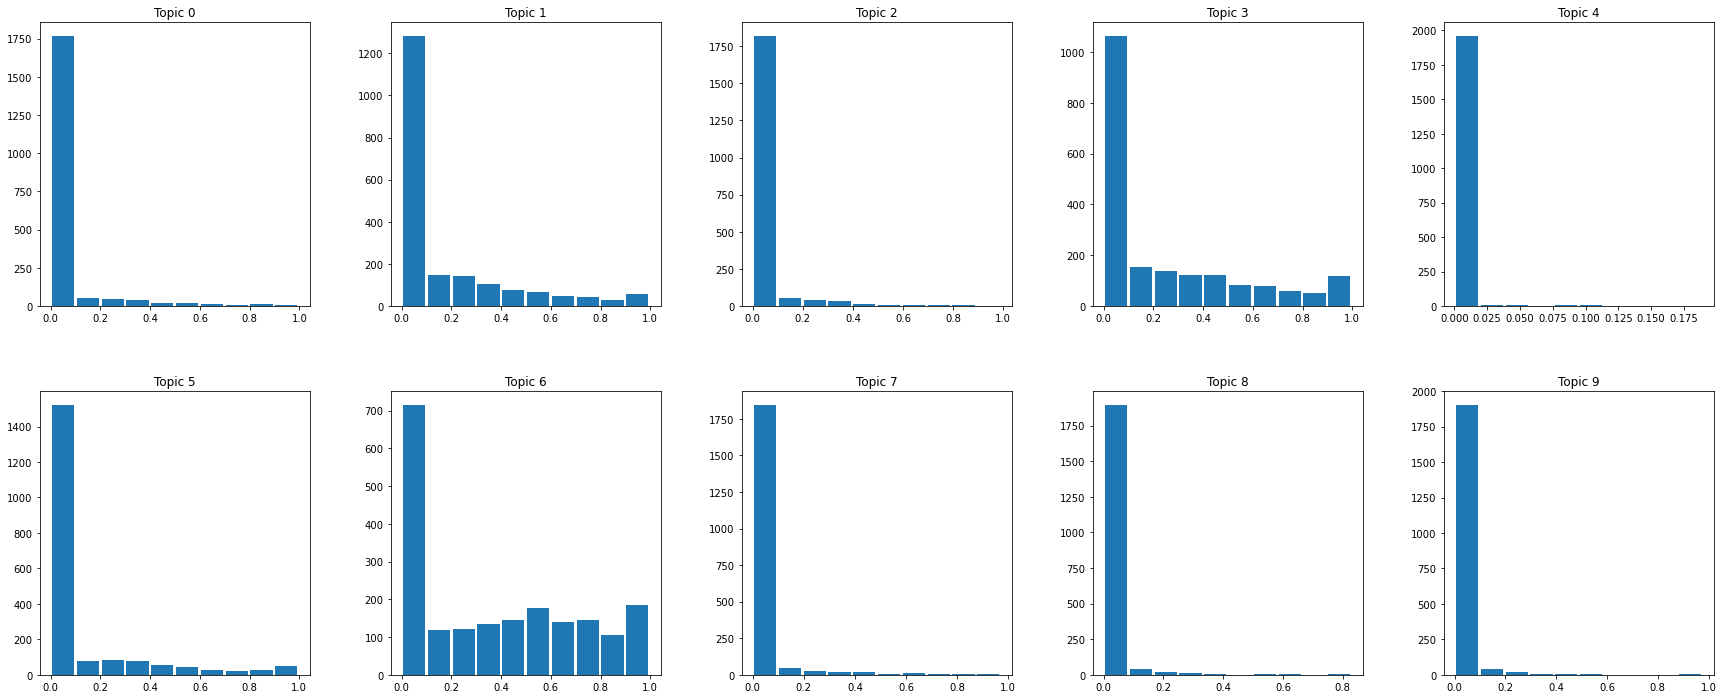

In [53]:
topics_dist.hist(grid=False, figsize=(30,12), layout=(2,5), rwidth=0.9);

In [54]:
predictor = list(topics_dist.columns[1:])
X = topics_dist.iloc[:,1:]
k = len(predictor)
y = combined.Label.astype(float)

### split the data into training and testing dataset

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

In [56]:
inn = theano.shared(X_train.values)
out = theano.shared(y_train.values)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, β0]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 452 seconds.
The number of effective samples is smaller than 25% for some parameters.


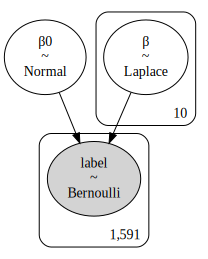

In [57]:
# Get the sampling results for comparison

with pm.Model() as sampling_model: 
    
    # Intercept term
    β0 = pm.Normal('β0', mu=0, sd=1)
    
    # Beta coefficients for predictor variables
    β = pm.Laplace('β', mu = 0.0, b = 5.0, shape=k)
    
    # Calculate logit from the normal variables, and add intercept
    logit = pm.math.dot(inn,β) + β0
    logistic = pm.math.sigmoid(logit)

    # Pass the logits to a Bernoulli outcome, with the observed data
    y_pred = pm.Bernoulli('label', p=logistic, observed=out)

    # Sample
    trace_main = pm.sample(10000, cores=4, random_seed=666)
    
# Graph the logistic model
pm.model_to_graphviz(sampling_model)

In [58]:
inn.set_value(X_test.values)
out.set_value(y_test.values)

with sampling_model:
    ppc = pm.sample_posterior_predictive(trace_main, samples=500, progressbar=False, random_seed=666)

C:\Users\15182\anaconda3\lib\site-packages\pymc3\sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [59]:
pred = ppc['label'].mean(axis=0) > 0.5
pred = pred.astype(int)

In [60]:
confusion_matrix(y_test, pred)

array([[ 18, 167],
       [ 22, 191]], dtype=int64)

In [61]:
accuracy_score(y_test, pred)*100

52.51256281407035

In [62]:
print(classification_report(y_test, pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.45      0.10      0.16       185
           1       0.53      0.90      0.67       213

    accuracy                           0.53       398
   macro avg       0.49      0.50      0.41       398
weighted avg       0.49      0.53      0.43       398



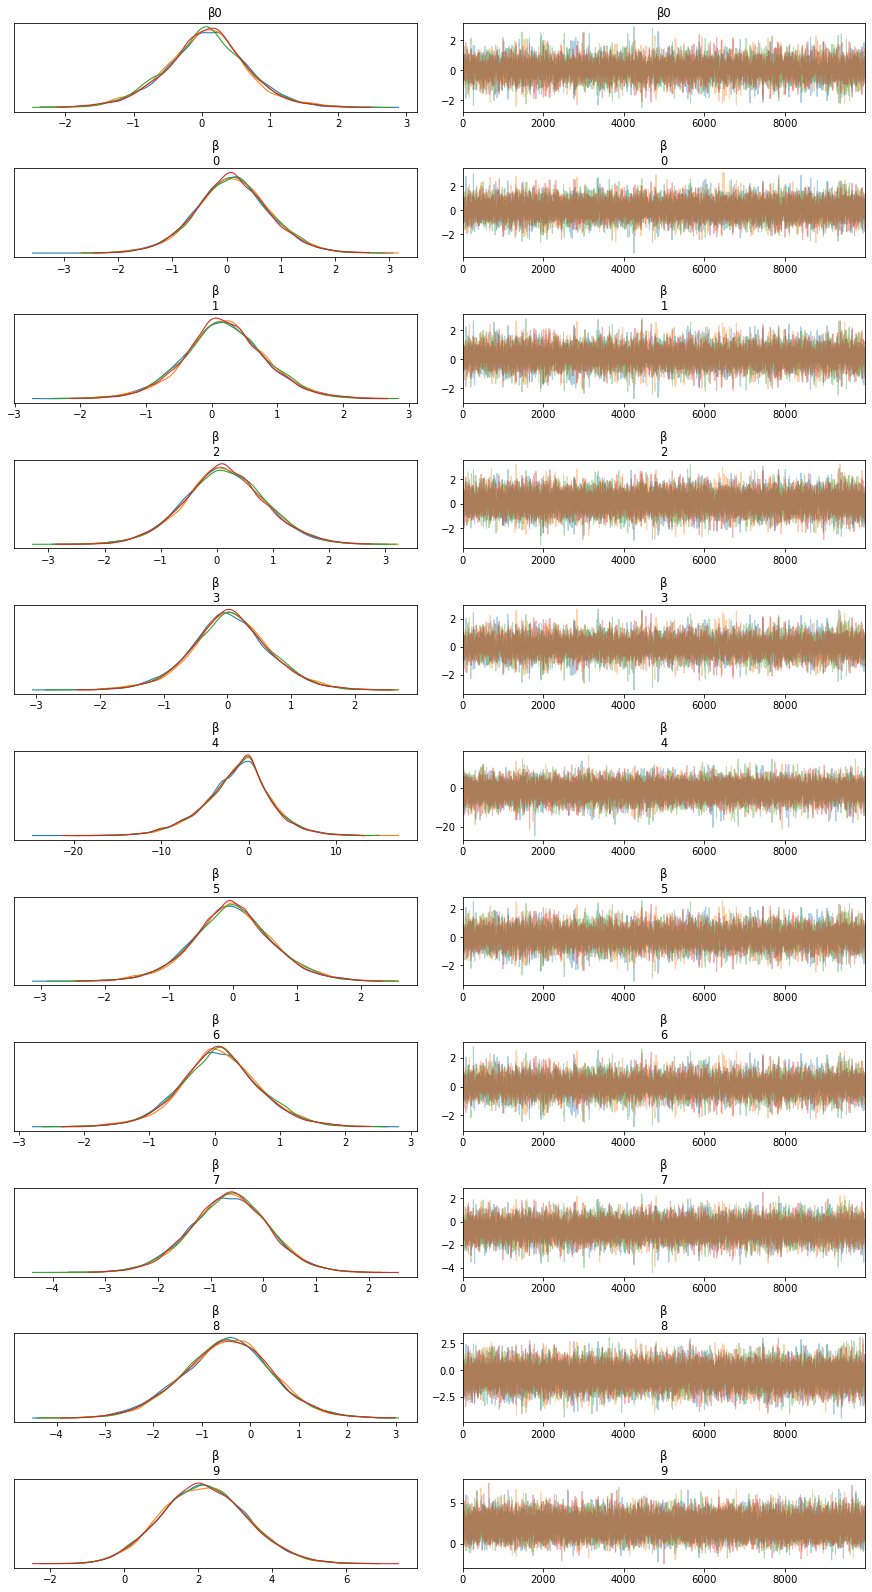

In [63]:
with sampling_model:
    az.plot_trace(trace_main)

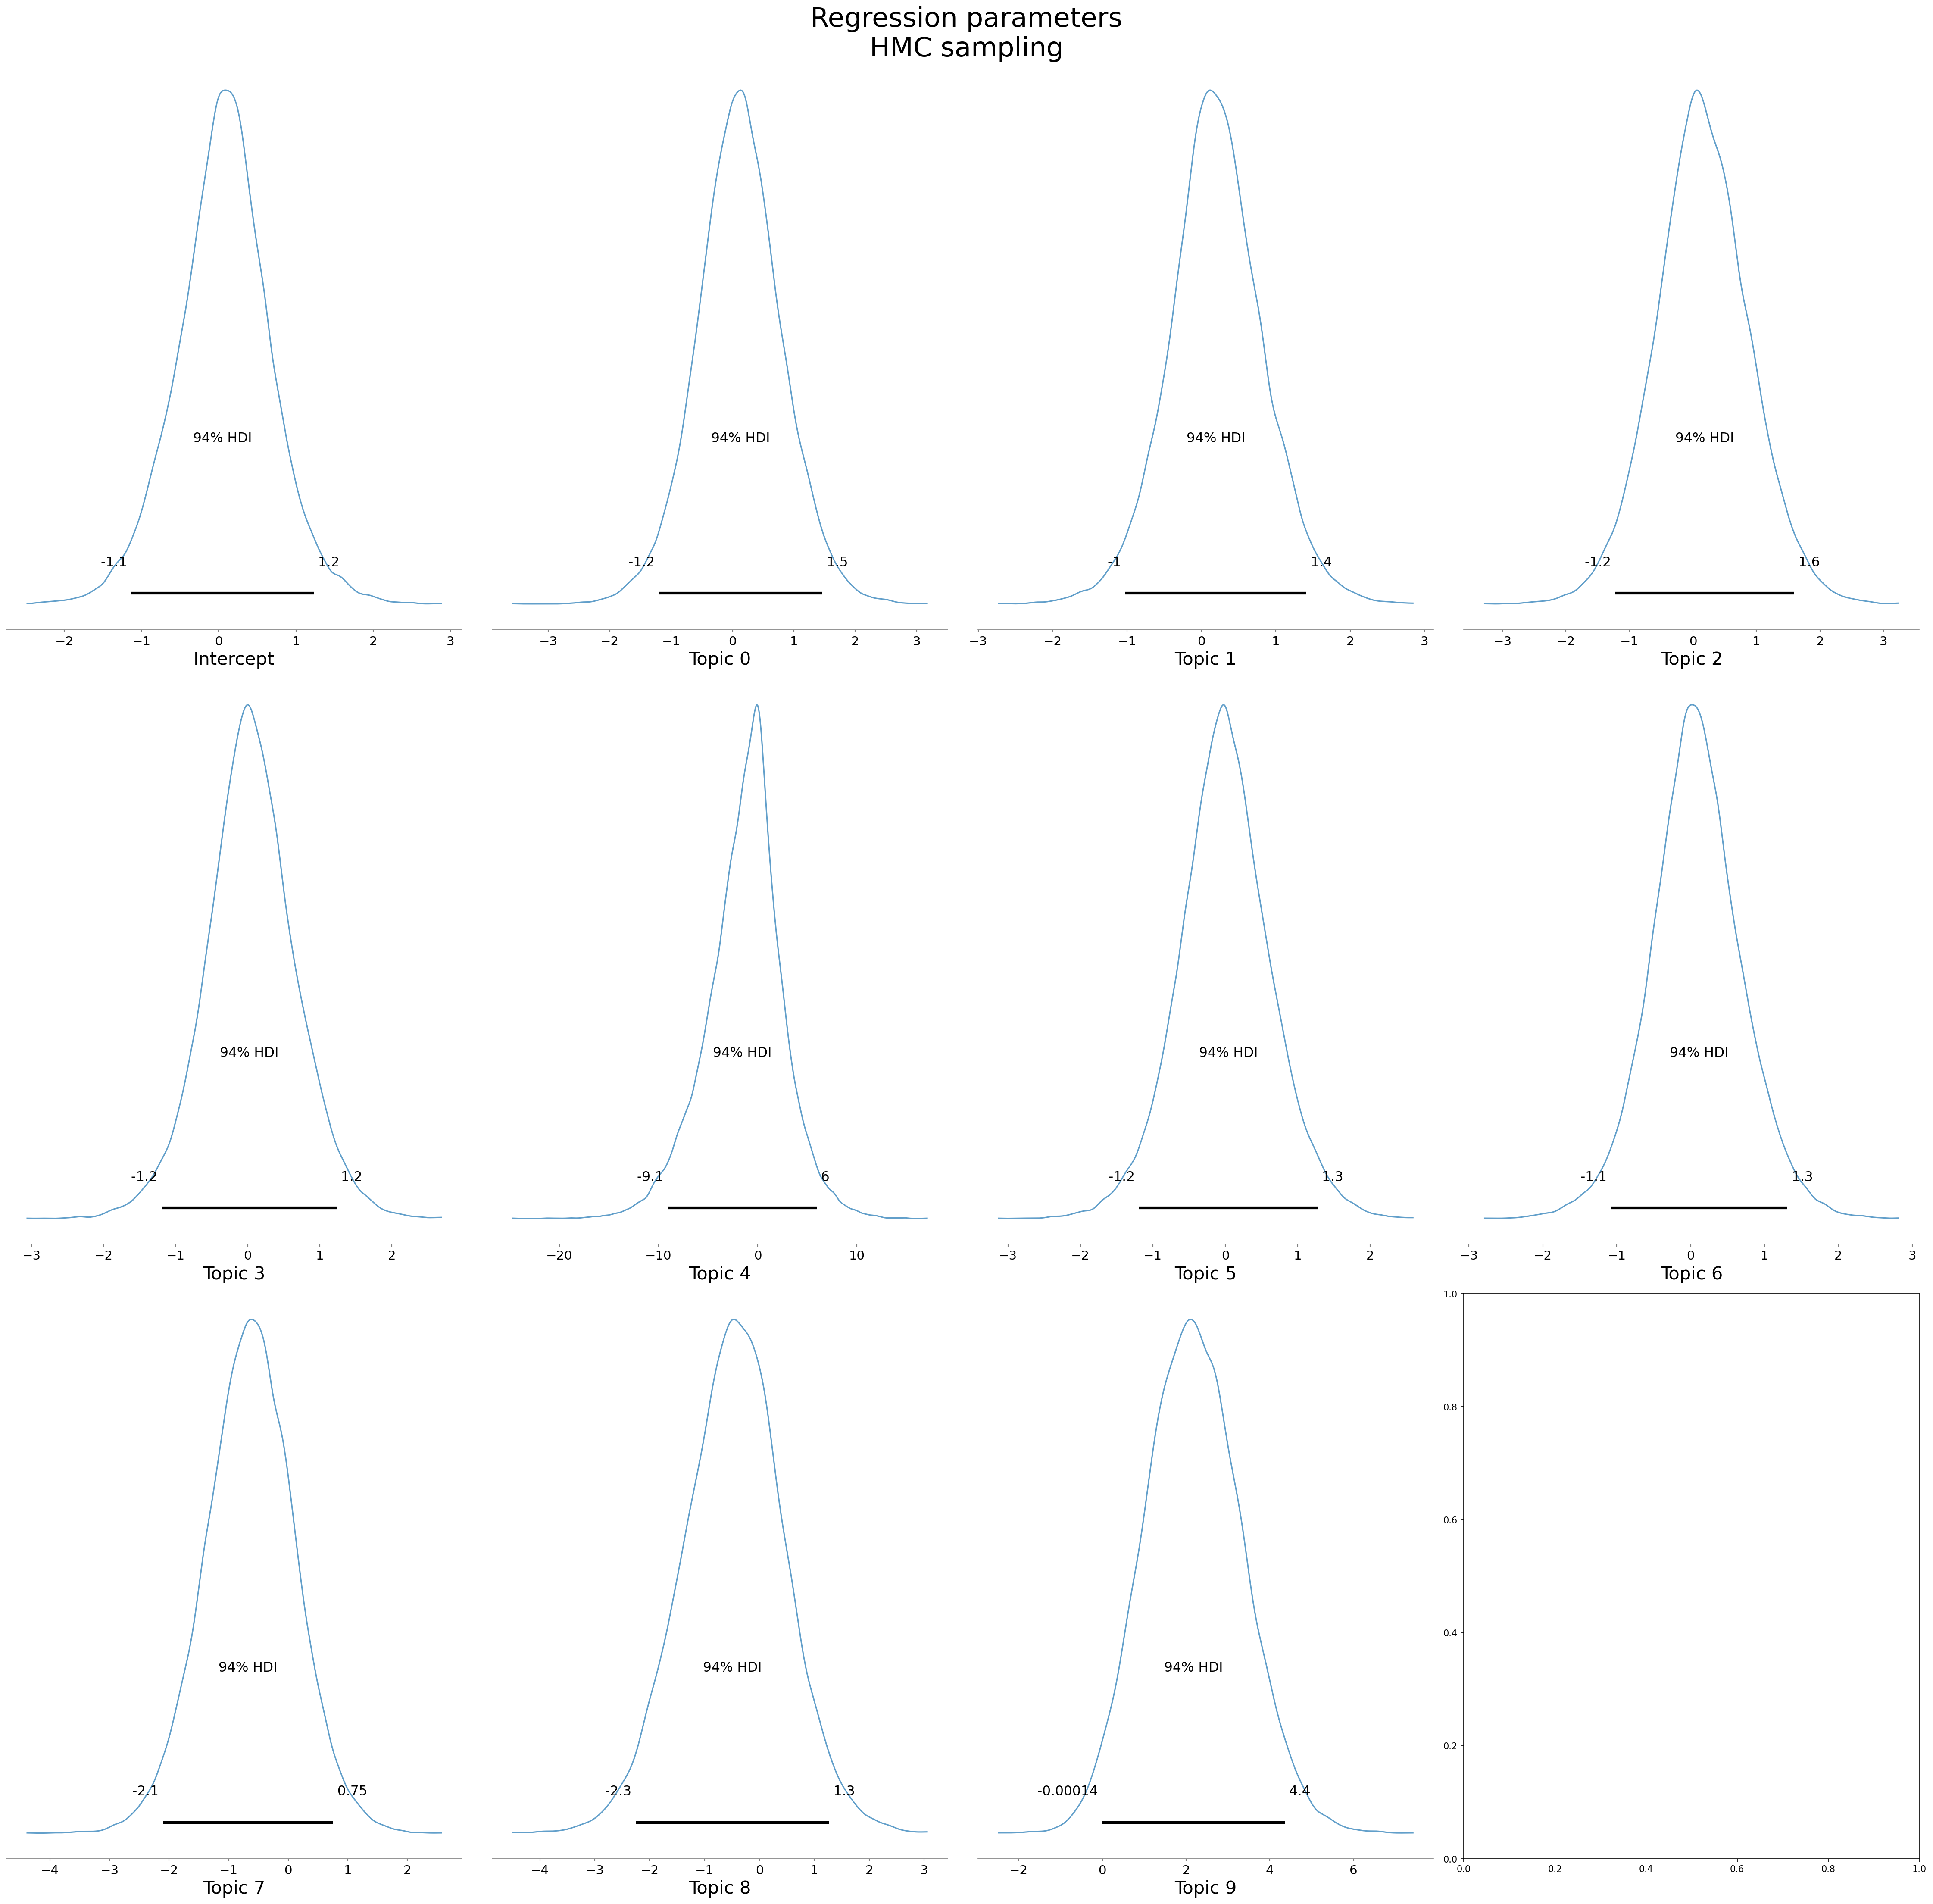

In [64]:
burnin = 100
sample_intercept = trace_main['β0'][burnin:]
sample_betas = trace_main['β'][burnin:]

# Plot posteriors

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 30), dpi=150, constrained_layout=False)

for ax, estimate_sampling, xlabel in zip(axes.ravel(),
                               [sample_intercept] + [sample_betas[:,i] for i in range(k)],
                               ['Intercept'] + predictor):
    
    pm.plot_posterior(estimate_sampling, ax=ax,point_estimate=None,  alpha=0.7)
    
    ax.set_title("")

    ax.set_xlabel(xlabel, fontsize=20)

plt.suptitle("Regression parameters\nHMC sampling", fontsize=30)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

### Number of Topics = 50

In [65]:
lda_model = LDA_trains(headlines = combined['headlines'], N_topics = 50, N_words = 10)

In [66]:
topics= lda_model.Topics()

In [67]:
topics_dist = lda_model.Predict_Topics(combined['headlines'])

In [68]:
topics

Word 0      Word 1   Word 2   Word 3    Word 4       Word 5  \
Topics                                                                  
0            say       china     year     kill      make          ban   
1        protest        isra    world   israel    govern         forc   
2        nuclear         say     kill     year     plant        japan   
3         israel        gaza     isra      say      year         kill   
4           shoe  bilderberg      say  thrower    extrem        polic   
5            say        year     gaza   israel      forc         kill   
6            say        year    world   govern     state        korea   
7        countri        year      amp     bank     china        right   
8           year       korea     bank     news      drug           uk   
9        reactor      libyan  tsunami    japan   nuclear         kill   
10         world        news  murdoch      use      abus         face   
11       marriag       world      sex    peopl       say          war   
12           say      russia  russian  protest      year          new   
13           say    wikileak   govern   assang    kileak         year   
14           say        year   govern    world      kill       minist   
15          year        kill      say    peopl     world        polic   
16        israel        gaza      say     isra      news  palestinian   
17         korea         new    north     year       use         make   
18      children        gaza      war     kill    report          die   
19         korea         say    north    world      year       attack   
20          year         say     kill    peopl     world      protest   
21           say        year   govern  countri     world         kill   
22           say        year     kill    polic     world          new   
23           nsa      israel  snowden      say   surveil       edward   
24          lade         bin    osama   attack       say         kill   
25           say        gaza     kill    polic       new        syria   
26           say        year   minist   report     north        korea   
27       protest       egypt   govern    libya  egyptian        peopl   
28           say       state     year    world    govern       leader   
29       protest      public      gay      men      year          new   
30        israel         say     isra     gaza       new          war   
31           say        year     forc      use     world        state   
32           say        year     kill    world       new       govern   
33          year       world     kill    state       new          say   
34           say        kill     isra   attack    israel        world   
35          iran      israel      say     year    govern  palestinian   
36       foreign      turkey   govern      day    israel         pass   
37           say      govern      new     year        uk        world   
38           say      israel      war     year      kill        world   
39       georgia      russia      war   israel   ossetia     georgian   
40           say     russian   ukrain      war     syria        troop   
41           say      govern     year      use     world      countri   
42           say       state   attack      isi     islam       russia   
43          kill      attack     year      say     peopl        world   
44           say      attack     kill    peopl       war       govern   
45           say         new     year    right     korea          war   
46          year       state    world      say   protest       presid   
47           say      israel     year     isra      kill        peopl   
48        attack       hebdo   charli     year       new        islam   
49          year         say      ban      gay  militari        peopl   

         Word 6       Word 7   Word 8   Word 9  
Topics                                          
0         polic        right  nuclear     news  
1          make  palestinian     year    peopl  
2          lade  

In [69]:
topics_dist

headlines   Topic 0   Topic 1  \
0     georgia down two russian warplan countri move ...  0.000091  0.000091   
1     wont america nato help us wont help us help ir...  0.000131  0.000131   
2     rememb ador year old sing open ceremoni fake r...  0.000104  0.000104   
3     u refus israel weapon attack iran report presi...  0.000104  0.000104   
4     expert admit legalis drug war south osetia pic...  0.000114  0.000114   
...                                                 ...       ...       ...   
1984  rclay rb share suspend trade tank pe say churc...  0.000081  0.000081   
1985  scientist australia want save great barrier re...  0.000070  0.000070   
1986  plosion airport istanbul meni former presid te...  0.000079  0.000079   
1987  maica propos marijuana dispens tourist airport...  0.000072  0.000072   
1988  year old woman mexico citi final receiv birth ...  0.000066  0.000066   

       Topic 2   Topic 3   Topic 4   Topic 5   Topic 6   Topic 7   Topic 8  \
0     0.000091  0.000091  0.000091  0.000091  0.000091  0.000091  0.000091   
1     0.000131  0.000131  0.000131  0.000131  0.000131  0.000131  0.000131   
2     0.000104  0.008231  0.000104  0.000104  0.000104  0.000104  0.000104   
3     0.000104  0.000104  0.000104  0.000104  0.000104  0.000104  0.000104   
4     0.000114  0.000114  0.000114  0.000114  0.000114  0.000114  0.000114   
...        ...       ...       ...       ...       ...       ...       ...   
1984  0.000081  0.000081  0.000081  0.000081  0.000081  0.000081  0.000081   
1985  0.000070  0.000070  0.000070  0.000070  0.000070  0.000070  0.000070   
1986  0.000079  0.000079  0.000079  0.000079  0.000079  0.000079  0.000079   
1987  0.000072  0.000072  0.000072  0.000072  0.000072  0.000072  0.000072   
1988  0.000066  0.000066  0.000066  0.000066  0.000066  0.000066  0.000066   

      ...  Topic 40  Topic 41  Topic 42  Topic 43  Topic 44  Topic 45  \
0     ...  0.000091  0.000091  0.000091  0.000091  0.000091  0.000091   
1     ...  0.000131  0.000131  0.000131  0.000131  0.000131  0.000131   
2     ...  0.000104  0.000104  0.000104  0.000104  0.000104  0.000104   
3     ...  0.000104  0.000104  0.000104  0.000104  0.000104  0.000104   
4     ...  0.000114  0.015237  0.000114  0.000114  0.000114  0.000114   
...   ...       ...       ...       ...       ...       ...       ...   
1984  ...  0.000081  0.000081  0.000081  0.000081  0.000081  0.000081   
1985  ...  0.000070  0.000070  0.000070  0.000070  0.000070  0.000070   
1986  ...  0.000079  0.000079  0.000079  0.000079  0.000079  0.000079   
1987  ...  0.000072  0.000072  0.000072  0.000072  0.000072  0.000072   
1988  ...  0.000066  0.000066  0.000066  0.000066  0.000066  0.000066   

      Topic 46  Topic 47  Topic 48  Topic 49  
0     0.000091  0.000091  0.000091  0.000091  
1     0.000131  0.000131  0.000131  0.000131  
2     0.000104  0.000104  0.000104  0.000104  
3     0.000104  0.000104  0.000104  0.000104  
4     0.000114  0.000114  0.000114  0.000114  
...        ...       ...       ...       ...  
1984  0.000081  0.948279  0.000081  0.000081  
1985  0.000070  0.000070  0.000070  0.000070  
1986  0.000079  0.000079  0.000079  0.000079  
1987  0.000072  0.000072  0.000072  0.000072  
1988  0.000066  0.000066  0.000066  0.000066  

[1989 rows x 51 columns]

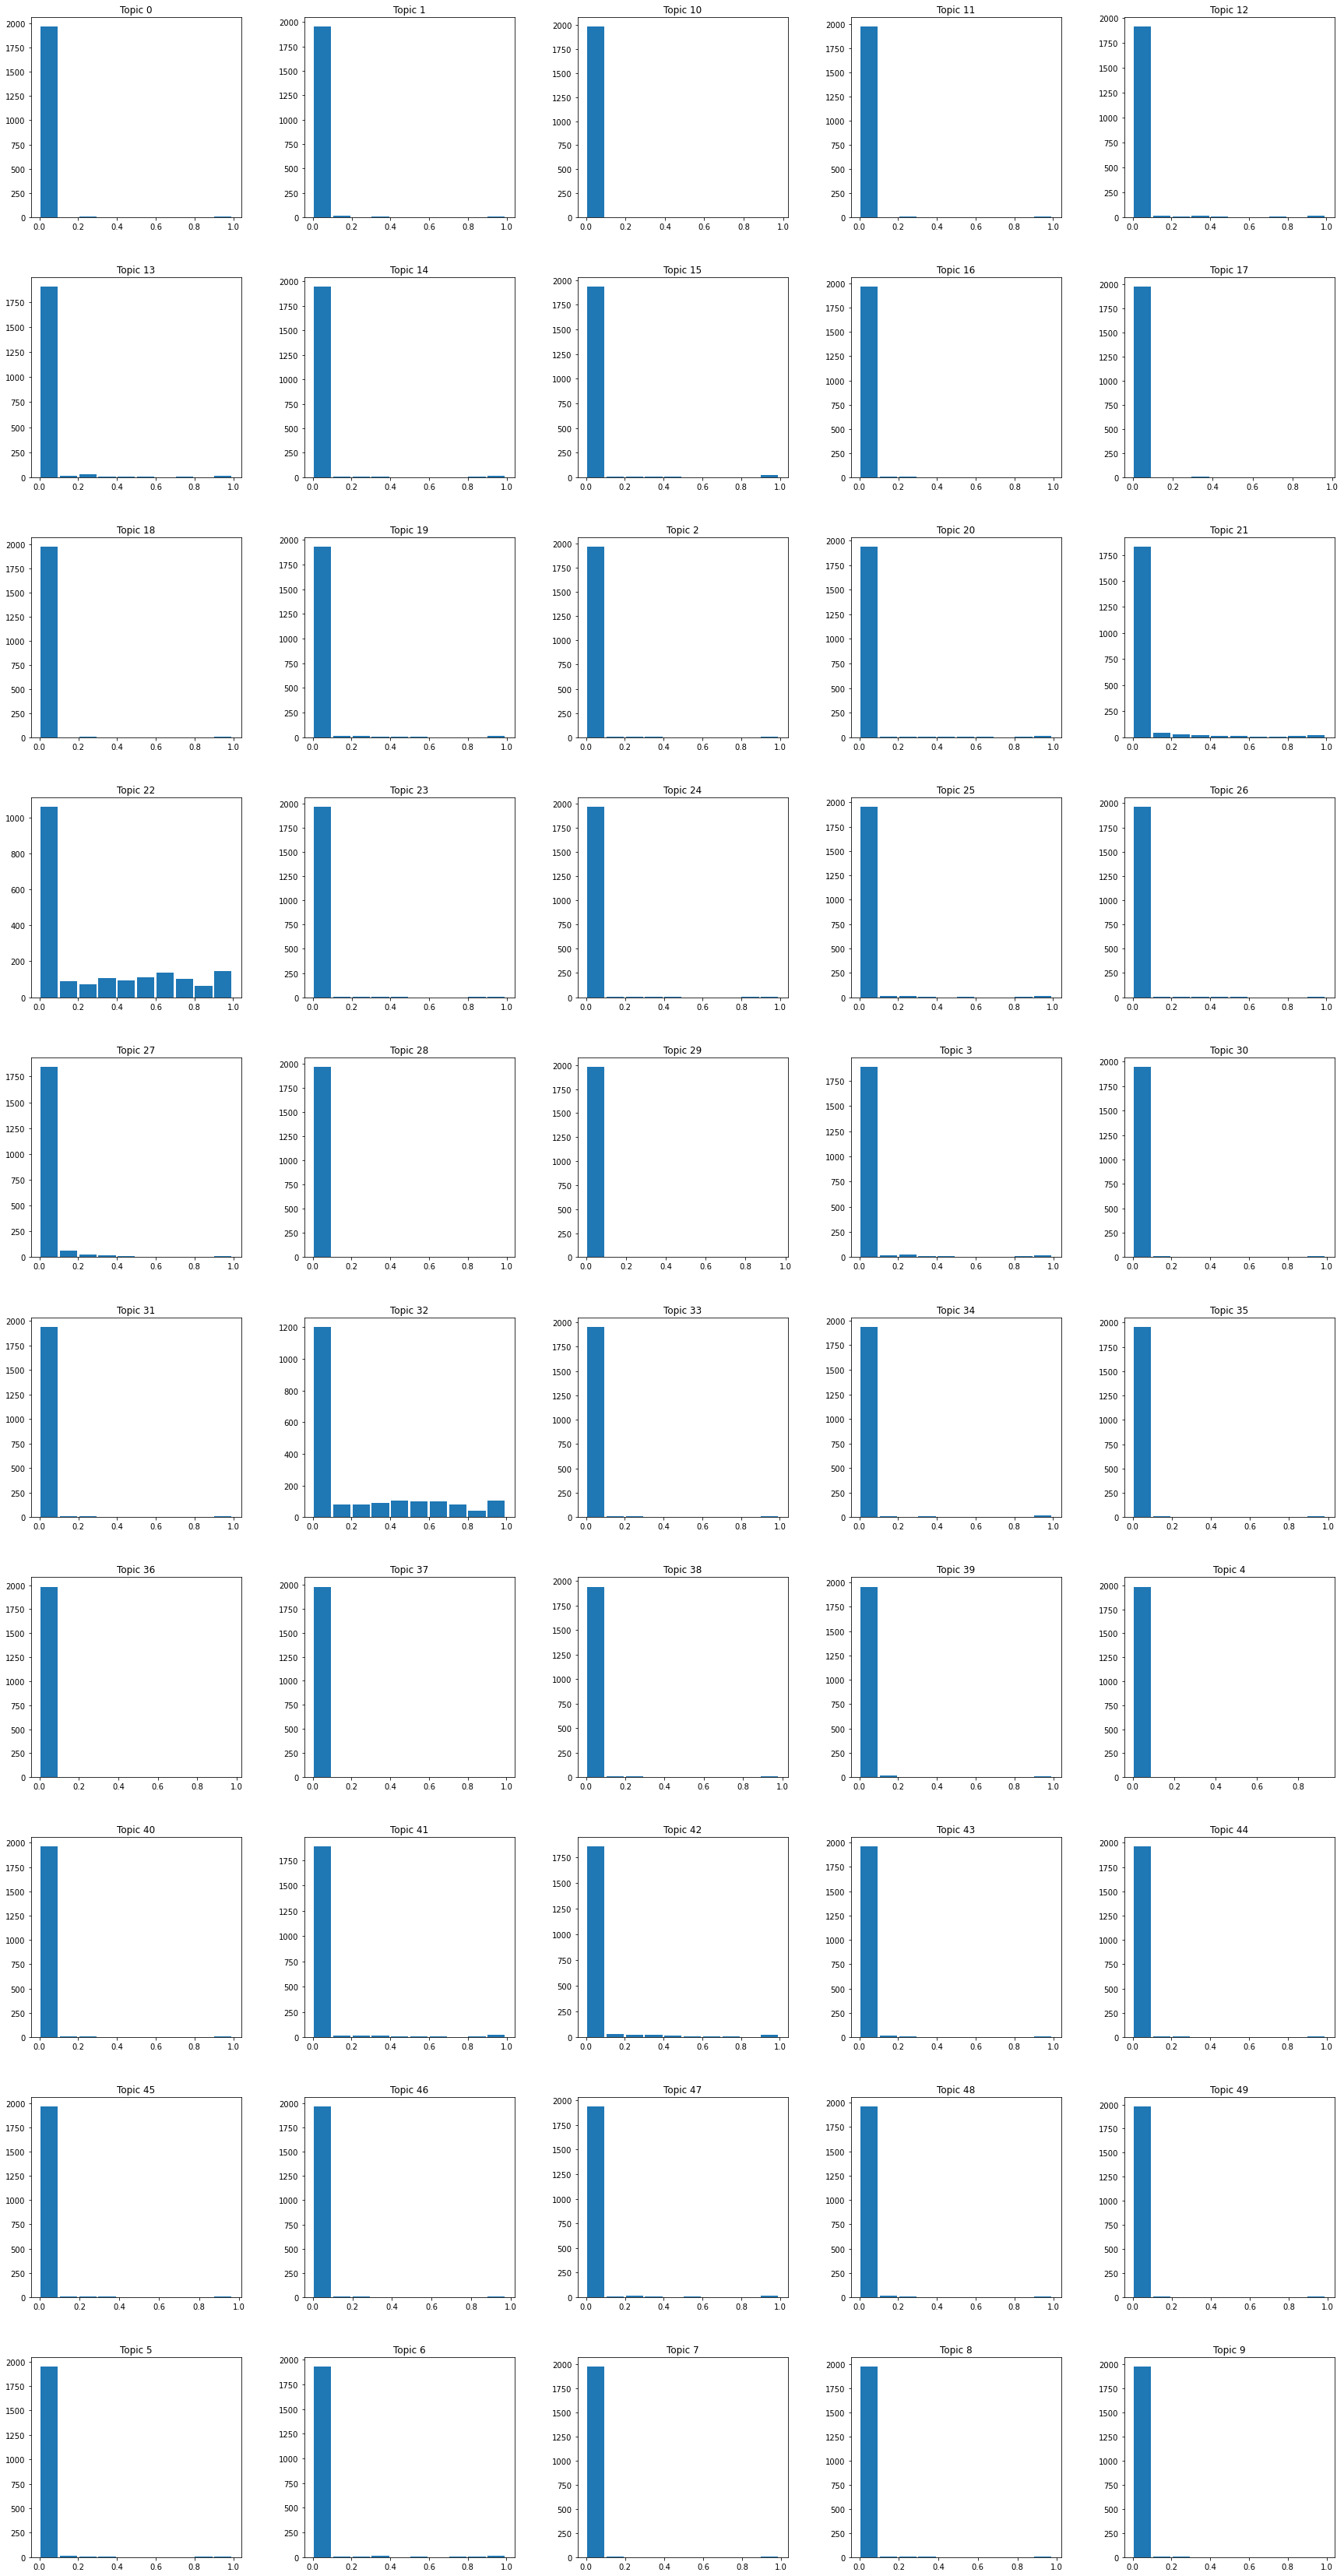

In [70]:
topics_dist.hist(grid=False, figsize=(30,60), layout=(10,5), rwidth=0.9);

In [71]:
predictor = list(topics_dist.columns[1:])
X = topics_dist.iloc[:,1:]
k = len(predictor)
y = combined.Label.astype(float)

### split the data into training and testing dataset

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

In [73]:
inn = theano.shared(X_train.values)
out = theano.shared(y_train.values)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, β0]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 238 seconds.
The number of effective samples is smaller than 10% for some parameters.


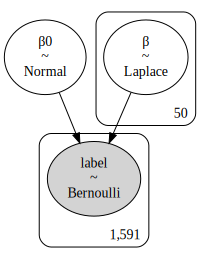

In [74]:
# Get the sampling results for comparison

with pm.Model() as sampling_model: 
    
    # Intercept term
    β0 = pm.Normal('β0', mu=0, sd=1)
    
    # Beta coefficients for predictor variables
    β = pm.Laplace('β', mu = 0.0, b = 5.0, shape=k)
    
    # Calculate logit from the normal variables, and add intercept
    logit = pm.math.dot(inn,β) + β0
    logistic = pm.math.sigmoid(logit)

    # Pass the logits to a Bernoulli outcome, with the observed data
    y_pred = pm.Bernoulli('label', p=logistic, observed=out)

    # Sample
    trace_main = pm.sample(10000, cores=4, random_seed=666)
    
# Graph the logistic model
pm.model_to_graphviz(sampling_model)

In [75]:
inn.set_value(X_test.values)
out.set_value(y_test.values)

with sampling_model:
    ppc = pm.sample_posterior_predictive(trace_main, samples=500, progressbar=False, random_seed=666)

C:\Users\15182\anaconda3\lib\site-packages\pymc3\sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [76]:
pred = ppc['label'].mean(axis=0) > 0.5
pred = pred.astype(int)

In [77]:
confusion_matrix(y_test, pred)

array([[ 44, 141],
       [ 54, 159]], dtype=int64)

In [78]:
accuracy_score(y_test, pred)*100

51.005025125628144

In [79]:
print(classification_report(y_test, pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.45      0.24      0.31       185
           1       0.53      0.75      0.62       213

    accuracy                           0.51       398
   macro avg       0.49      0.49      0.47       398
weighted avg       0.49      0.51      0.48       398



C:\Users\15182\anaconda3\lib\site-packages\arviz\plots\traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (51), generating only 20 plots
  warnings.warn(


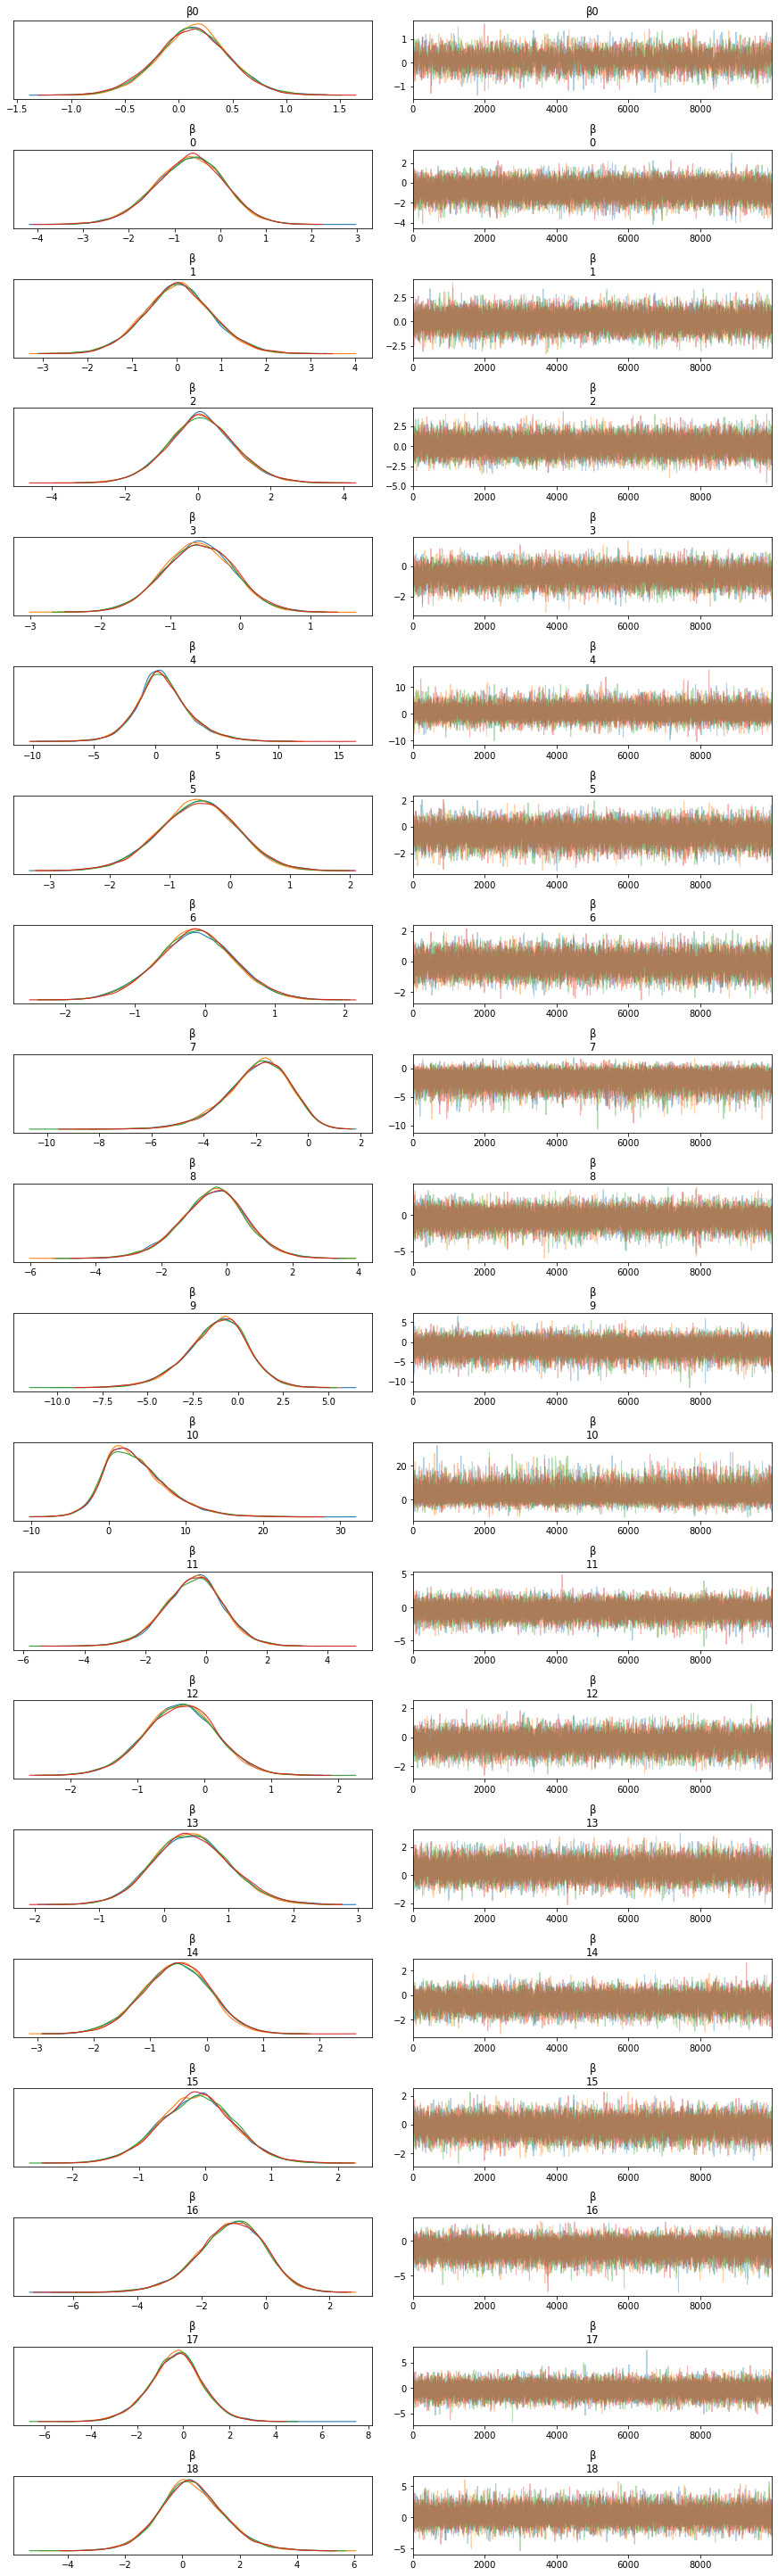

In [80]:
with sampling_model:
    az.plot_trace(trace_main)

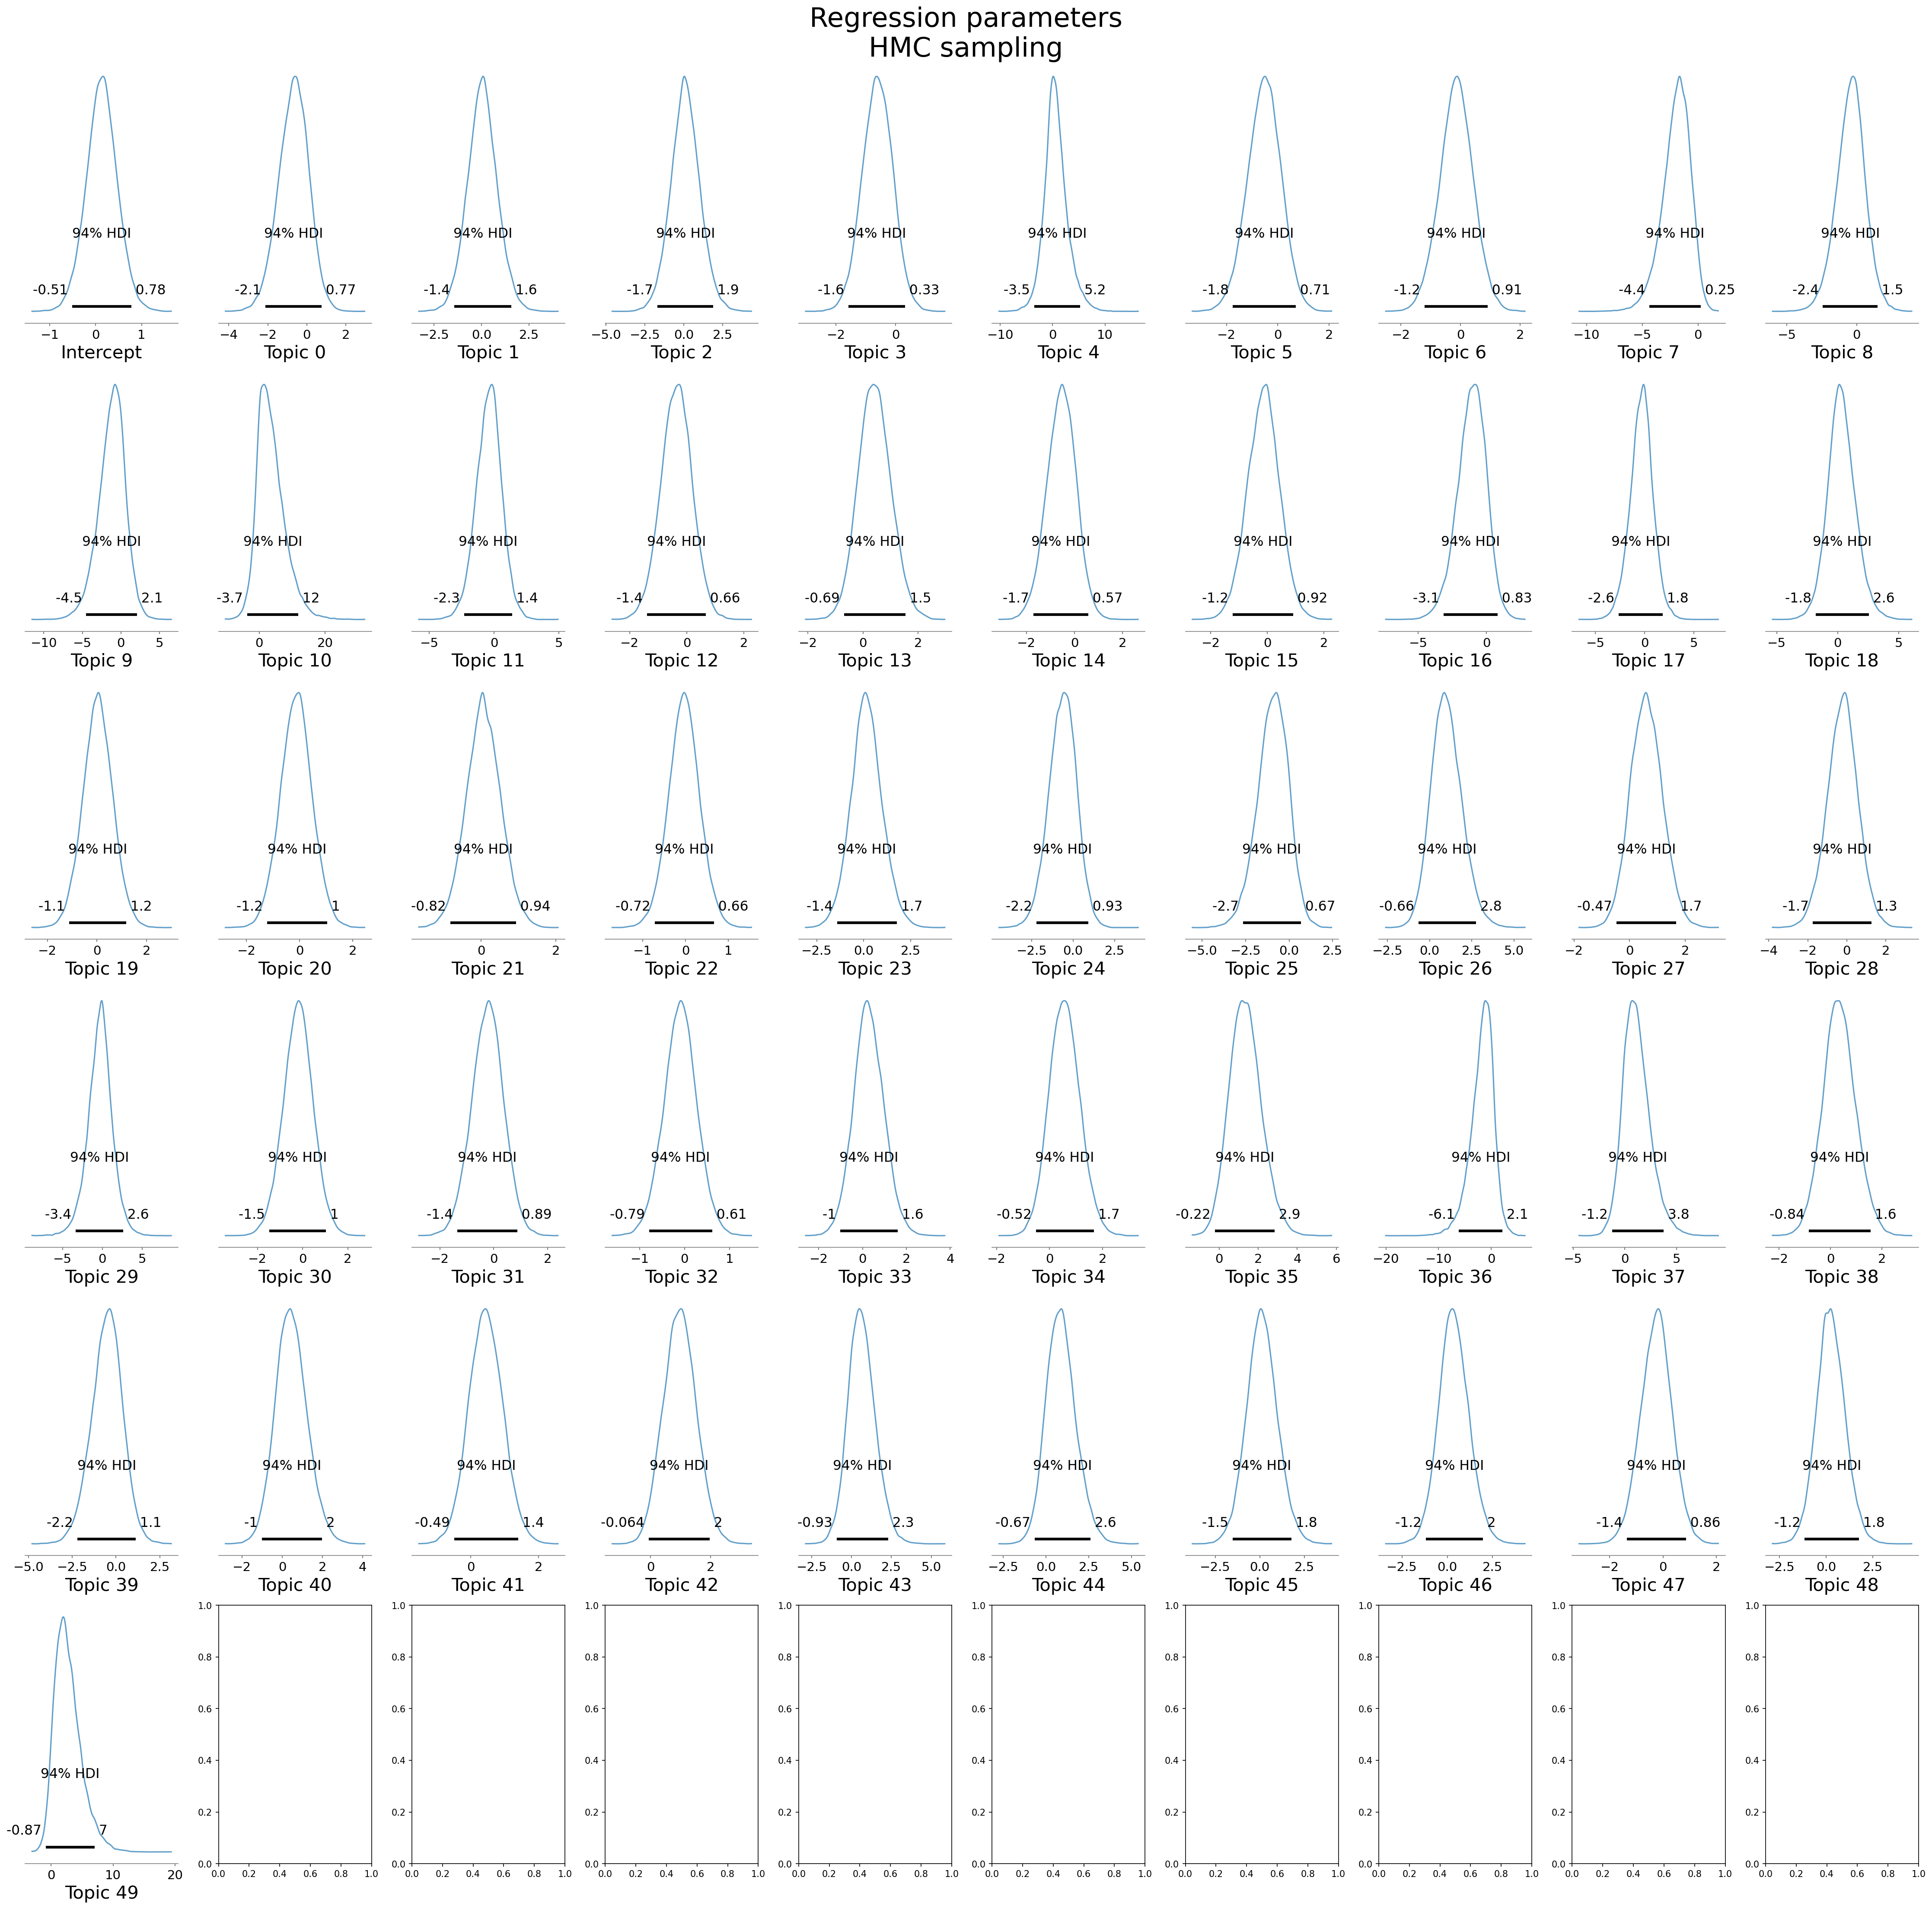

In [81]:
burnin = 100
sample_intercept = trace_main['β0'][burnin:]
sample_betas = trace_main['β'][burnin:]

# Plot posteriors

fig, axes = plt.subplots(nrows=6, ncols=10, figsize=(30, 30), dpi=150, constrained_layout=False)

for ax, estimate_sampling, xlabel in zip(axes.ravel(),
                               [sample_intercept] + [sample_betas[:,i] for i in range(k)],
                               ['Intercept'] + predictor):
    
    pm.plot_posterior(estimate_sampling, ax=ax,point_estimate=None,  alpha=0.7)
    
    ax.set_title("")

    ax.set_xlabel(xlabel, fontsize=20)

plt.suptitle("Regression parameters\nHMC sampling", fontsize=30)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

### Number of Topics = 100

In [82]:
lda_model = LDA_trains(headlines = combined['headlines'], N_topics = 100, N_words = 10)

In [83]:
topics= lda_model.Topics()

In [84]:
topics_dist = lda_model.Predict_Topics(combined['headlines'])

In [85]:
topics.iloc[20:25]

Word 0   Word 1   Word 2   Word 3  Word 4  Word 5       Word 6  Word 7  \
Topics                                                                          
20       year    peopl  protest  countri    kill   polic       govern     new   
21        say     year   govern     make  presid    bank        world     new   
22        say     year     kill    world     war  israel        peopl   polic   
23       gaza   israel     isra    peopl     say     aid  palestinian  attack   
24        say  snowden     lade      bin    raid  minist         year   osama   

         Word 8 Word 9  
Topics                  
20          say  world  
21      protest  death  
22      countri    new  
23        china  itali  
24        death  video

In [86]:
topics_dist

headlines   Topic 0   Topic 1  \
0     georgia down two russian warplan countri move ...  0.000045  0.000045   
1     wont america nato help us wont help us help ir...  0.000065  0.000065   
2     rememb ador year old sing open ceremoni fake r...  0.000052  0.000052   
3     u refus israel weapon attack iran report presi...  0.000052  0.000052   
4     expert admit legalis drug war south osetia pic...  0.000057  0.000057   
...                                                 ...       ...       ...   
1984  rclay rb share suspend trade tank pe say churc...  0.000041  0.000041   
1985  scientist australia want save great barrier re...  0.000035  0.000035   
1986  plosion airport istanbul meni former presid te...  0.000039  0.000039   
1987  maica propos marijuana dispens tourist airport...  0.000036  0.000036   
1988  year old woman mexico citi final receiv birth ...  0.000033  0.000033   

       Topic 2   Topic 3   Topic 4   Topic 5   Topic 6   Topic 7   Topic 8  \
0     0.000045  0.000045  0.000045  0.000045  0.000045  0.000045  0.000045   
1     0.000065  0.000065  0.000065  0.000065  0.000065  0.000065  0.000065   
2     0.000052  0.000052  0.000052  0.000052  0.000052  0.000052  0.000052   
3     0.000052  0.000052  0.000052  0.000052  0.000052  0.000052  0.000052   
4     0.000057  0.000057  0.000057  0.000057  0.000057  0.000057  0.000057   
...        ...       ...       ...       ...       ...       ...       ...   
1984  0.000041  0.000041  0.000041  0.000041  0.000041  0.000041  0.000041   
1985  0.000035  0.000035  0.000035  0.000035  0.000035  0.000035  0.000035   
1986  0.000039  0.000039  0.000039  0.000039  0.000039  0.000039  0.000039   
1987  0.000036  0.000036  0.000036  0.000036  0.000036  0.000036  0.000036   
1988  0.000033  0.033104  0.000033  0.000033  0.000033  0.000033  0.000033   

      ...  Topic 90  Topic 91  Topic 92  Topic 93  Topic 94  Topic 95  \
0     ...  0.000045  0.000045  0.000045  0.000045  0.000045  0.000045   
1     ...  0.000065  0.000065  0.000065  0.000065  0.000065  0.000065   
2     ...  0.000052  0.000052  0.000052  0.000052  0.000052  0.000052   
3     ...  0.000052  0.000052  0.000052  0.000052  0.000052  0.000052   
4     ...  0.000057  0.000057  0.000057  0.000057  0.000057  0.000057   
...   ...       ...       ...       ...       ...       ...       ...   
1984  ...  0.000041  0.000041  0.000041  0.000041  0.000041  0.000041   
1985  ...  0.000035  0.000035  0.000035  0.004660  0.000035  0.000035   
1986  ...  0.000039  0.000039  0.000039  0.000039  0.000039  0.000039   
1987  ...  0.000036  0.000036  0.000036  0.000036  0.000036  0.000036   
1988  ...  0.000033  0.000033  0.000033  0.000033  0.000033  0.000033   

      Topic 96  Topic 97  Topic 98  Topic 99  
0     0.000045  0.000045  0.000045  0.000045  
1     0.000065  0.000065  0.000065  0.000065  
2     0.000052  0.000052  0.000052  0.000052  
3     0.000052  0.000052  0.000052  0.000052  
4     0.000057  0.000057  0.000057  0.000057  
...        ...       ...       ...       ...  
1984  0.000041  0.019803  0.000041  0.000041  
1985  0.000035  0.000035  0.000035  0.000035  
1986  0.000039  0.000039  0.000039  0.000039  
1987  0.000036  0.000036  0.000036  0.000036  
1988  0.000033  0.000033  0.000033  0.000033  

[1989 rows x 101 columns]

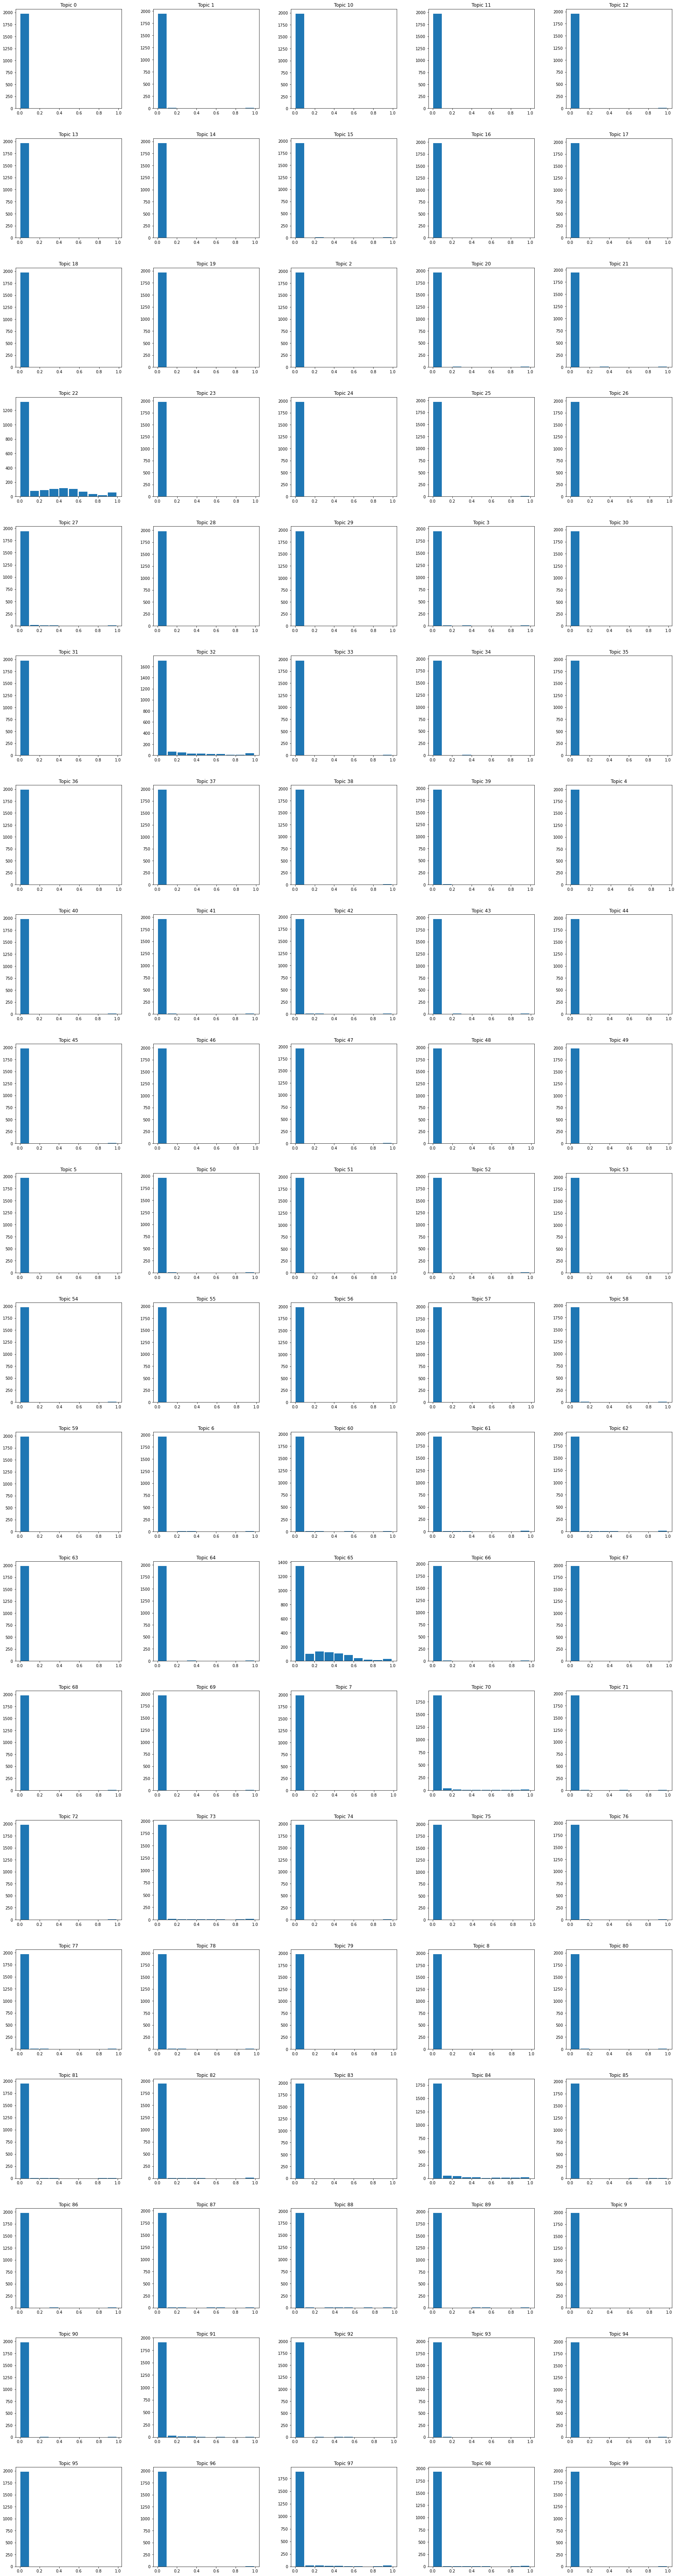

In [87]:
topics_dist.hist(grid=False, figsize=(30,120), layout=(20,5), rwidth=0.9);

In [88]:
predictor = list(topics_dist.columns[1:])
X = topics_dist.iloc[:,1:]
k = len(predictor)
y = combined.Label.astype(float)

### split the data into training and testing dataset

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

In [90]:
inn = theano.shared(X_train.values)
out = theano.shared(y_train.values)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, β0]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 270 seconds.
The number of effective samples is smaller than 25% for some parameters.


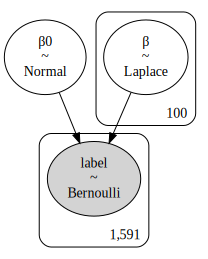

In [91]:
# Get the sampling results for comparison

with pm.Model() as sampling_model: 
    
    # Intercept term
    β0 = pm.Normal('β0', mu=0, sd=1)
    
    # Beta coefficients for predictor variables
    β = pm.Laplace('β', mu = 0.0, b = 5.0, shape=k)
    
    # Calculate logit from the normal variables, and add intercept
    logit = pm.math.dot(inn,β) + β0
    logistic = pm.math.sigmoid(logit)

    # Pass the logits to a Bernoulli outcome, with the observed data
    y_pred = pm.Bernoulli('label', p=logistic, observed=out)

    # Sample
    trace_main = pm.sample(10000, cores=4, random_seed=666)
    
# Graph the logistic model
pm.model_to_graphviz(sampling_model)

In [92]:
inn.set_value(X_test.values)
out.set_value(y_test.values)

with sampling_model:
    ppc = pm.sample_posterior_predictive(trace_main, samples=500, progressbar=False, random_seed=666)

C:\Users\15182\anaconda3\lib\site-packages\pymc3\sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [93]:
pred = ppc['label'].mean(axis=0) > 0.5
pred = pred.astype(int)

In [94]:
confusion_matrix(y_test, pred)

array([[ 50, 135],
       [ 59, 154]], dtype=int64)

In [95]:
accuracy_score(y_test, pred)*100

51.256281407035175

In [96]:
print(classification_report(y_test, pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.46      0.27      0.34       185
           1       0.53      0.72      0.61       213

    accuracy                           0.51       398
   macro avg       0.50      0.50      0.48       398
weighted avg       0.50      0.51      0.49       398



In [ ]:
with sampling_model:
    az.plot_trace(trace_main)

C:\Users\15182\anaconda3\lib\site-packages\arviz\plots\traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (101), generating only 20 plots
  warnings.warn(


In [ ]:
burnin = 100
sample_intercept = trace_main['β0'][burnin:]
sample_betas = trace_main['β'][burnin:]

# Plot posteriors

fig, axes = plt.subplots(nrows=21, ncols=5, figsize=(30, 126), dpi=150, constrained_layout=False)

for ax, estimate_sampling, xlabel in zip(axes.ravel(),
                               [sample_intercept] + [sample_betas[:,i] for i in range(k)],
                               ['Intercept'] + predictor):
    
    pm.plot_posterior(estimate_sampling, ax=ax,point_estimate=None,  alpha=0.7)
    
    ax.set_title("")

    ax.set_xlabel(xlabel, fontsize=20)

plt.suptitle("Regression parameters\nHMC sampling", fontsize=30)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()